### Import Libraries

In [51]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.model_selection import StratifiedKFold
from cvxopt import matrix, solvers

### Simulate & Prepare Dataset

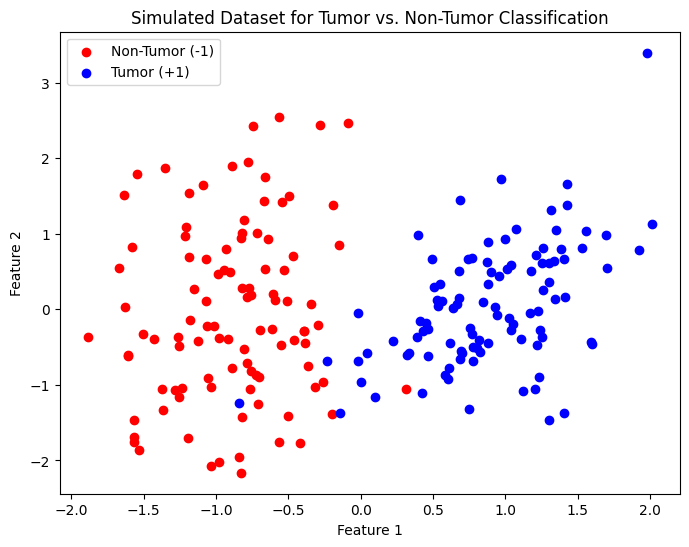

Training labels: [-1  1]
Testing labels: [-1  1]


In [53]:
X, y = make_classification(
    n_samples=200,
    n_features=2,
    n_informative=2,
    n_redundant=0,
    n_clusters_per_class=1,
    class_sep=2,
    random_state=42
)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
y = np.where(y == 0, -1, 1)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

plt.figure(figsize=(8, 6))
plt.scatter(X_scaled[y == -1, 0], X_scaled[y == -1, 1], color="red", label="Non-Tumor (-1)")
plt.scatter(X_scaled[y == 1, 0], X_scaled[y == 1, 1], color="blue", label="Tumor (+1)")
plt.title("Simulated Dataset for Tumor vs. Non-Tumor Classification")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend()
plt.show()

print(f"Training labels: {np.unique(y_train)}")
print(f"Testing labels: {np.unique(y_test)}")

### Computing Kernel Matrix

In [36]:
import numpy as np

# Define rbf kernel
def rbf_kernel(x1, x2, gamma=0.5):
    """
    Compute the RBF kernel between two data points.
    """
    distance = np.linalg.norm(x1 - x2)**2  
    return np.exp(-gamma * distance)

# Initialize kernel matrix
def compute_kernel_matrix(x1, gamma):
    n_samples = x1.shape[0] 
    K = np.zeros((n_samples, n_samples)) 
    
    for i in range(n_samples):
        for j in range(n_samples):
            K[i, j] = rbf_kernel(x1[i], x1[j], gamma=0.5)

    return K
            
K = compute_kernel_matrix(X_train, 0.5)

print("Kernel matrix shape:", K.shape)
print("Kernel matrix (first 5 rows and columns):\n", K[:5, :5])

Kernel matrix shape: (160, 160)
Kernel matrix (first 5 rows and columns):
 [[1.         0.06223421 0.06601654 0.48858348 0.00471662]
 [0.06223421 1.         0.67579467 0.41910279 0.60559128]
 [0.06601654 0.67579467 1.         0.52536132 0.52111894]
 [0.48858348 0.41910279 0.52536132 1.         0.10445112]
 [0.00471662 0.60559128 0.52111894 0.10445112 1.        ]]


### Train SVM Dual Formulation

In [55]:
# Train SVM Using Dual Formulation
def train_svm_dual(X_train, y_train, gamma, C):
    n_samples = X_train.shape[0]
    K = compute_kernel_matrix(X_train, gamma)
    
    # Define quadratic programming parameters
    P = matrix(np.outer(y_train, y_train) * K)
    q = matrix(-np.ones(n_samples))
    A = matrix(y_train.astype(float), (1, n_samples))
    b = matrix(0.0)
    G = matrix(np.vstack((-np.eye(n_samples), np.eye(n_samples))))
    h = matrix(np.hstack((np.zeros(n_samples), C * np.ones(n_samples))))
    
    # Solve quadratic programming problem
    solvers.options['show_progress'] = False
    solution = solvers.qp(P, q, G, h, A, b)
    alphas = np.ravel(solution['x'])
    
    # Compute bias term
    support_vectors = alphas > 1e-5
    b_values = [y_train[i] - np.sum(alphas * y_train * K[i]) for i in range(n_samples) if support_vectors[i]]
    b = np.mean(b_values)
    
    return alphas, b, support_vectors

### Evaluation Metrics

Classification Report:
               precision    recall  f1-score   support

          -1       1.00      1.00      1.00        23
           1       1.00      1.00      1.00        17

    accuracy                           1.00        40
   macro avg       1.00      1.00      1.00        40
weighted avg       1.00      1.00      1.00        40

Confusion Matrix:
 [[23  0]
 [ 0 17]]


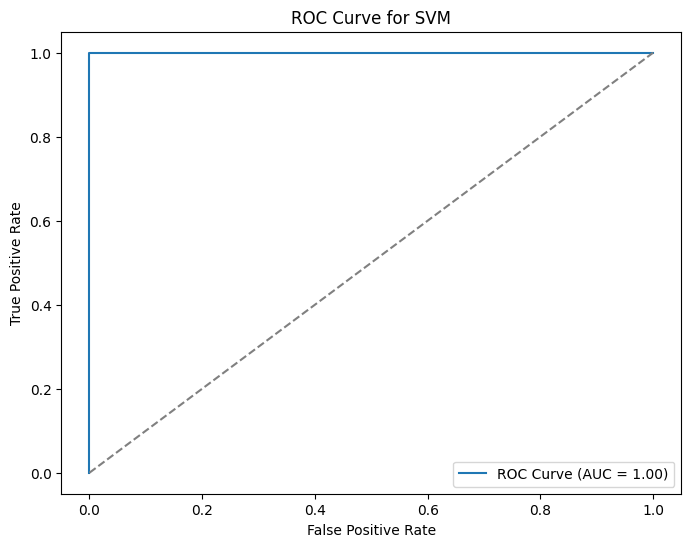

In [50]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

def decision_function(X_train, y_train, alphas, X_test, b, gamma):
    decision_values = np.zeros(len(X_test))
    for i, x in enumerate(X_test):
        kernel_sum = sum(alphas[j] * y_train[j] * rbf_kernel(X_train[j], x, gamma) for j in range(len(X_train)))
        decision_values[i] = kernel_sum + b
    return decision_values

gamma = 0.5
C = 1.0
alphas, b, support_vectors = train_svm_dual(X_train, y_train, gamma, C)

decision_values = decision_function(X_train, y_train, alphas, X_test, b, gamma)
y_pred = np.sign(decision_values)

print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

fpr, tpr, _ = roc_curve(y_test, decision_values)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for SVM")
plt.legend()
plt.show()

### Hyperparameter Tuning

In [58]:
def tune_hyperparameters(X_train, y_train, gamma_values, C_values):
    best_gamma, best_C, best_accuracy = None, None, 0
    for gamma in gamma_values:
        for C in C_values:
            accuracies = []
            skf = StratifiedKFold(n_splits=5)
            for train_idx, val_idx in skf.split(X_train, y_train):
                X_train_cv, X_val_cv = X_train[train_idx], X_train[val_idx]
                y_train_cv, y_val_cv = y_train[train_idx], y_train[val_idx]
                
                alphas, b, _ = train_svm_dual(X_train_cv, y_train_cv, gamma, C)
                val_decision = decision_function(X_train_cv, y_train_cv, alphas, X_val_cv, b, gamma)
                val_pred = np.sign(val_decision)
                accuracies.append(np.mean(val_pred == y_val_cv))
            
            mean_accuracy = np.mean(accuracies)
            if mean_accuracy > best_accuracy:
                best_gamma, best_C, best_accuracy = gamma, C, mean_accuracy
    return best_gamma, best_C

gamma_values = [0.1, 0.5, 1.0]
C_values = [0.1, 1.0, 10.0]
best_gamma, best_C = tune_hyperparameters(X_train, y_train, gamma_values, C_values)
print(f"Best Gamma: {best_gamma}, Best C: {best_C}")

Best Gamma: 0.1, Best C: 0.1


In [59]:
alphas, b, support_vectors = train_svm_dual(X_train, y_train, best_gamma, best_C)

decision_values = decision_function(X_train, y_train, alphas, X_test, b, best_gamma)
y_pred = np.sign(decision_values)

# Classification report and confusion matrix
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

Classification Report:
               precision    recall  f1-score   support

          -1       1.00      1.00      1.00        23
           1       1.00      1.00      1.00        17

    accuracy                           1.00        40
   macro avg       1.00      1.00      1.00        40
weighted avg       1.00      1.00      1.00        40

Confusion Matrix:
 [[23  0]
 [ 0 17]]


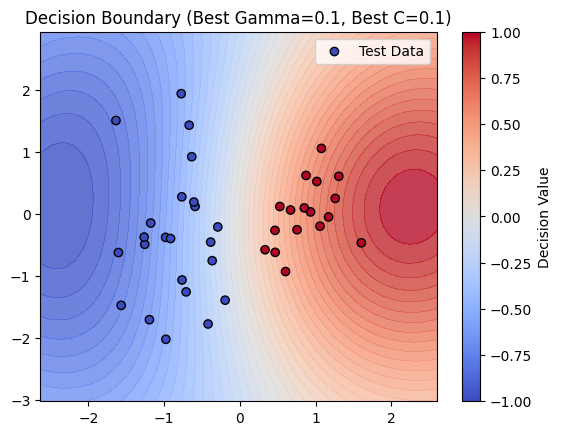

In [60]:
xx, yy = np.meshgrid(
    np.linspace(X_test[:, 0].min() - 1, X_test[:, 0].max() + 1, 200),
    np.linspace(X_test[:, 1].min() - 1, X_test[:, 1].max() + 1, 200)
)
grid = np.c_[xx.ravel(), yy.ravel()]
decision_values = decision_function(X_train, y_train, alphas, grid, b, best_gamma)
decision_values = decision_values.reshape(xx.shape)

plt.contourf(xx, yy, decision_values, levels=50, cmap="coolwarm", alpha=0.8)
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap="coolwarm", edgecolors="k", label="Test Data")
plt.title(f"Decision Boundary (Best Gamma={best_gamma}, Best C={best_C})")
plt.colorbar(label="Decision Value")
plt.legend()
plt.show()

In [ ]:
# ------------------------------------------------------------------------------------# 

In [176]:
from scipy.optimize import minimize

# Step 4a: Define the dual objective function
def objective_function(alpha):
    alpha = np.ravel(alpha)  # Ensure alpha is 1D
    quadratic_term = 0.5 * np.dot(alpha, np.dot(K, alpha))
    linear_term = np.sum(alpha)
    return quadratic_term - linear_term


# Step 4b: Define the equality constraint
def equality_constraint(alpha):
    return np.dot(alpha, y_train)

# Step 4c: Set up bounds and initial guess
n_samples = X_train.shape[0]

# Initialize the kernel matrix
P = np.zeros((n_samples, n_samples))

# Compute the kernel matrix manually
for i in range(n_samples):
    for j in range(n_samples):
        P[i, j] = y_train[i] * y_train[j] * rbf_kernel(X_train[i], X_train[j], gamma=0.5)
        
# Define the regularization parameter
C = 100.0  # Regularization parameter; adjust as needed

# Define bounds and constraints
bounds = [(0, C) for _ in range(n_samples)]

#bounds = [(0, C) for _ in range(n_samples)]  # Each alpha must be between 0 and C
constraints = {'type': 'eq', 'fun': lambda alpha: np.dot(alpha, y_train)}

#constraints = {'type': 'eq', 'fun': lambda alpha: np.dot(alpha, y_train)}  # Equality constraint

# Initial guess for alpha
initial_guess = np.zeros(n_samples)

# Solve the optimization problem
result = minimize(objective_function, initial_guess, bounds=bounds, constraints=constraints, method='SLSQP')

print("Kernel matrix (first 5x5):\n", K[:5, :5])

# Retrieve the optimized alpha values
alphas = result.x
print("Optimized alphas:", alphas)



Kernel matrix (first 5x5):
 [[1.         0.05308693 0.01549528 0.33579554 0.00261878]
 [0.05308693 1.         0.14436375 0.2543499  0.39186092]
 [0.01549528 0.14436375 1.         0.37025185 0.353078  ]
 [0.33579554 0.2543499  0.37025185 1.         0.09231857]
 [0.00261878 0.39186092 0.353078   0.09231857 1.        ]]
Optimized alphas: [6.42059451e-01 6.18511928e-17 1.24723060e-16 0.00000000e+00
 0.00000000e+00 6.24246324e-01 1.27495399e-17 4.18756148e-17
 7.00022400e-02 3.89885323e-01 2.96420874e-16 1.09133419e-16
 0.00000000e+00 0.00000000e+00 0.00000000e+00 1.50693091e-16
 1.84687064e-17 0.00000000e+00 4.91182074e-01 1.68983073e-17
 1.05865566e-16 1.59165722e-01 6.38154622e-18 1.12502916e-16
 1.38261188e-17 5.45253437e-01 1.11219661e-16 0.00000000e+00
 0.00000000e+00 1.65615270e-16 7.22556403e-02 0.00000000e+00
 0.00000000e+00 3.86467253e-17 0.00000000e+00 1.18362690e-16
 1.33407689e-17 3.48858990e-17 2.25557664e-01 7.19368141e-17
 3.92311780e-17 0.00000000e+00 0.00000000e+00 0.00000

In [177]:
print("Sum of alpha * y_train:", np.dot(initial_guess, y_train))


Sum of alpha * y_train: 0.0


In [180]:
# Threshold to determine support vectors
threshold = 1e-5

# Count support vectors
support_vector_indices = alphas > threshold  # Boolean array
num_support_vectors = np.sum(support_vector_indices)

# Print results
print("Number of support vectors:", num_support_vectors)

# Optionally, print the indices and corresponding alpha values of support vectors
print("Indices of support vectors:", np.where(support_vector_indices)[0])
print("Alpha values of support vectors:", alphas[support_vector_indices])


Number of support vectors: 33
Indices of support vectors: [  0   5   8   9  18  21  25  30  38  52  53  55  61  62  64  82  89  96
 103 104 105 110 114 118 121 128 130 140 146 151 153 155 158]
Alpha values of support vectors: [0.64205945 0.62424632 0.07000224 0.38988532 0.49118207 0.15916572
 0.54525344 0.07225564 0.22555766 0.76026081 0.75152037 0.92189334
 0.03494144 0.05973364 0.08832726 0.08219196 0.14248905 0.55434204
 0.2948088  0.05676492 0.16510528 0.22513177 0.68634615 0.5755325
 0.08877632 0.00172977 0.08864757 0.60674194 0.10732853 0.64882747
 0.14495582 0.07236231 0.00484372]


In [182]:
# Select one support vector to calculate b
support_index = np.where(support_vector_indices)[0][0]  # Take the first support vector
x_support = X_train[support_index]         # Features of the support vector
y_support = y_train[support_index]         # Label of the support vector

# Compute the bias term
kernel_sum = 0
for i in range(n_samples):
    kernel_sum += alphas[i] * y_train[i] * rbf_kernel(X_train[i], x_support, gamma=0.5)

b = y_support - kernel_sum
print(f"Bias term (b): {b}")


Bias term (b): -0.24656947780116567


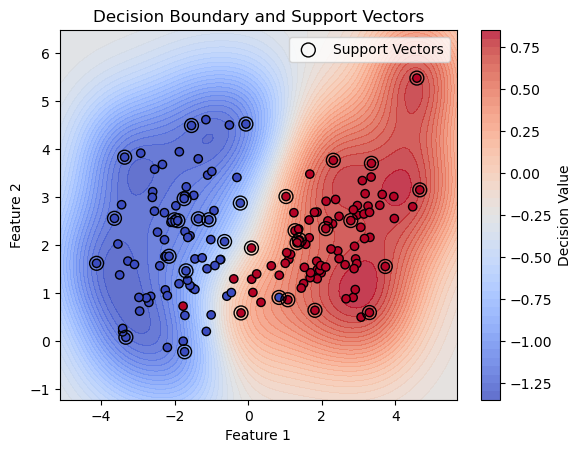

In [184]:
# Step 7: Define the decision function
def decision_function(X_test, X_train, y_train, alphas, b, gamma=0.5):
    """
    Compute the decision function for the test set.
    
    Parameters:
        X_test: Test dataset (or grid of points for visualization)
        X_train: Training data points
        y_train: Training labels
        alphas: Optimized alpha values
        b: Bias term
        gamma: Parameter for the RBF kernel

    Returns:
        Decision values for the test set
    """
    decision_values = np.zeros(X_test.shape[0])
    for i, x in enumerate(X_test):
        kernel_sum = 0
        for j in range(len(X_train)):
            kernel_sum += alphas[j] * y_train[j] * np.exp(-gamma * np.linalg.norm(X_train[j] - x) ** 2)
        decision_values[i] = kernel_sum + b
    return decision_values

# Generate a test set (you can also use your actual test data)
# For visualization, use a grid of points
x_min, x_max = X_train[:, 0].min() - 1, X_train[:, 0].max() + 1
y_min, y_max = X_train[:, 1].min() - 1, X_train[:, 1].max() + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))
grid_points = np.c_[xx.ravel(), yy.ravel()]

# Compute decision function values for the grid points
decision_values = decision_function(grid_points, X_train, y_train, alphas, b, gamma=0.5)

# Reshape decision values to match the grid shape
decision_values = decision_values.reshape(xx.shape)

# Plot the decision boundary
import matplotlib.pyplot as plt
plt.contourf(xx, yy, decision_values, levels=50, cmap="coolwarm", alpha=0.8)
plt.colorbar(label="Decision Value")

# Overlay the training points
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap="coolwarm", edgecolors="k")
plt.title("Decision Boundary and Support Vectors")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")

# Highlight the support vectors
support_vector_indices = alphas > 1e-5
plt.scatter(X_train[support_vector_indices, 0], X_train[support_vector_indices, 1], 
            facecolors="none", edgecolors="k", s=100, label="Support Vectors")
plt.legend()
plt.show()


In [185]:
# Step 8a: Compute decision function for test data
decision_function = np.zeros(X_test.shape[0])

for i in range(X_test.shape[0]):
    # Summing the kernel between test points and training points
    for j in range(n_samples):
        decision_function[i] += alphas[j] * y_train[j] * rbf_kernel(X_train[j], X_test[i], gamma=0.5)
    # Add the bias term
    decision_function[i] += b

# Step 8b: Assign labels based on decision function
predicted_labels = np.sign(decision_function)

# Step 8c: Calculate accuracy
accuracy = np.mean(predicted_labels == y_test)
print(f"Accuracy on test set: {accuracy * 100:.2f}%")

# Step 8d (Optional): Display predictions and decision values
print("Predicted labels:", predicted_labels)
print("Decision values:", decision_function)


Accuracy on test set: 97.50%
Predicted labels: [-1. -1. -1.  1.  1.  1. -1. -1. -1. -1. -1. -1.  1.  1. -1.  1. -1. -1.
  1.  1.  1.  1.  1. -1. -1. -1.  1. -1. -1.  1. -1.  1. -1. -1.  1. -1.
  1. -1.  1.  1.]
Decision values: [-1.28205529 -0.42033284 -0.28181131  0.50516251  0.69428401  0.77094042
 -1.22060255 -1.1322594  -0.8577965  -1.24944521 -0.32417335 -1.2332382
  0.74590763  0.69007079 -0.78098186  0.58447449 -1.30846033 -1.2854453
  0.75192363  0.64068397  0.74630415  0.59792876  0.71960289 -1.12244634
 -1.24972017 -0.92894655  0.07837232 -1.07800707 -0.43581253  0.74044423
 -0.96442672  0.66453019 -1.22345863 -1.09777586  0.4656762  -1.15357282
  0.73795901 -1.34503173  0.48278453  0.40861927]


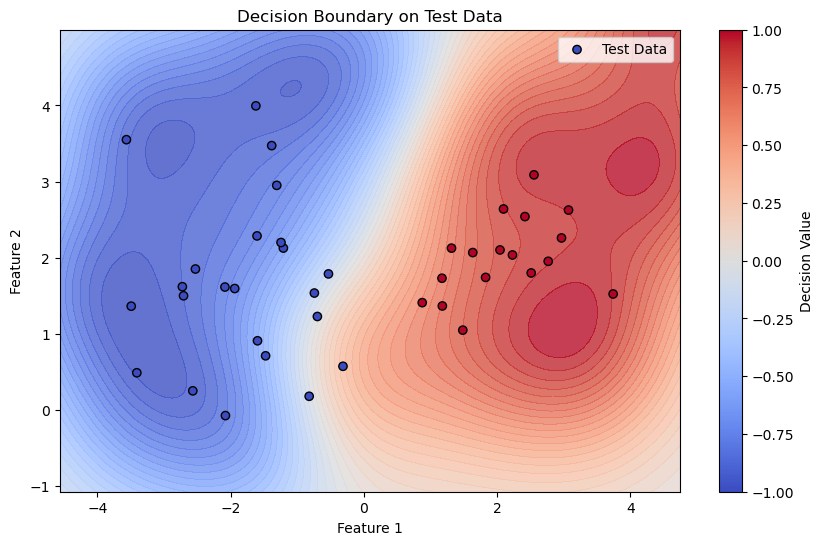

In [69]:
# Visualize the decision boundary with test data
xx, yy = np.meshgrid(np.linspace(X_test[:, 0].min() - 1, X_test[:, 0].max() + 1, 200),
                     np.linspace(X_test[:, 1].min() - 1, X_test[:, 1].max() + 1, 200))
grid = np.c_[xx.ravel(), yy.ravel()]

# Calculate decision values for the grid
decision_values = np.zeros(grid.shape[0])
for i in range(grid.shape[0]):
    for j in range(n_samples):
        decision_values[i] += alphas[j] * y_train[j] * rbf_kernel(X_train[j], grid[i], gamma=0.5)
    decision_values[i] += b

# Reshape decision values to match grid shape
decision_values = decision_values.reshape(xx.shape)

# Plot test data
plt.figure(figsize=(10, 6))
plt.contourf(xx, yy, decision_values, levels=50, cmap="coolwarm", alpha=0.8)
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap="coolwarm", edgecolors="k", label="Test Data")
plt.title("Decision Boundary on Test Data")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend()
plt.colorbar(label="Decision Value")
plt.show()


In [71]:
# Step 1: Decision function for training data
decision_function_train = np.zeros(len(X_train))
for i in range(len(X_train)):
    for j in range(len(X_train)):
        decision_function_train[i] += alphas[j] * y_train[j] * rbf_kernel(X_train[j], X_train[i], gamma=0.5)
    decision_function_train[i] += b  # Add the bias term

# Assign labels for training data
predicted_labels_train = np.sign(decision_function_train)

# Calculate training accuracy
training_accuracy = np.mean(predicted_labels_train == y_train)
print(f"Training Accuracy: {training_accuracy * 100:.2f}%")

# Step 2: Decision function for testing data (already calculated)
decision_function_test = np.zeros(len(X_test))
for i in range(len(X_test)):
    for j in range(len(X_train)):
        decision_function_test[i] += alphas[j] * y_train[j] * rbf_kernel(X_train[j], X_test[i], gamma=0.5)
    decision_function_test[i] += b  # Add the bias term

# Assign labels for testing data (already calculated in step 8)
predicted_labels_test = np.sign(decision_function_test)

# Calculate testing accuracy (already calculated)
testing_accuracy = np.mean(predicted_labels_test == y_test)
print(f"Testing Accuracy: {testing_accuracy * 100:.2f}%")


Training Accuracy: 97.50%
Testing Accuracy: 97.50%


In [73]:
from sklearn.metrics import confusion_matrix

# Training confusion matrix
cm_train = confusion_matrix(y_train, predicted_labels_train)
print("Training Confusion Matrix:\n", cm_train)

# Testing confusion matrix
cm_test = confusion_matrix(y_test, predicted_labels_test)
print("Testing Confusion Matrix:\n", cm_test)


Training Confusion Matrix:
 [[76  1]
 [ 3 80]]
Testing Confusion Matrix:
 [[22  1]
 [ 0 17]]


In [79]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, predicted_labels_test)
print("Confusion Matrix:\n", cm)


Confusion Matrix:
 [[22  1]
 [ 0 17]]


In [93]:
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
import numpy as np

# Set up k-fold cross-validation
kf = KFold(n_splits=5)
auc_scores = []

# Perform cross-validation
for train_index, test_index in kf.split(X_train):
    X_train_cv, X_test_cv = X_train[train_index], X_train[test_index]
    y_train_cv, y_test_cv = y_train[train_index], y_train[test_index]

    # Train your model on X_train_cv and y_train_cv
    # Use your current implementation of training the SVM
    
    # Predict on the validation set (X_test_cv)
    decision_function_cv = np.zeros(len(X_test_cv))
    for i in range(len(X_test_cv)):
        decision_function_cv[i] = sum(
            alphas[j] * y_train_cv[j] * rbf_kernel(X_train_cv[j], X_test_cv[i], gamma=0.5)
            for j in range(len(X_train_cv))
        ) + b
    
    # Calculate AUC for this fold
    auc = roc_auc_score(y_test_cv, decision_function_cv)
    auc_scores.append(auc)

# Print the mean AUC
print("Cross-validated AUC scores:", auc_scores)
print("Mean AUC:", np.mean(auc_scores))


Cross-validated AUC scores: [0.9803921568627451, 0.98828125, 0.9254901960784314, 1.0, 1.0]
Mean AUC: 0.9788327205882353


In [95]:
print("Training set label distribution:", np.bincount(y_train))
print("Testing set label distribution:", np.bincount(y_test))


ValueError: 'list' argument must have no negative elements

In [85]:
from sklearn.metrics import roc_curve, roc_auc_score
fpr, tpr, thresholds = roc_curve(y_test, decision_function)
auc_score = roc_auc_score(y_test, decision_function)
print("AUC Score:", auc_score)


AUC Score: 1.0


In [97]:
# Map -1 to 0 for training and testing labels
y_train_mapped = np.where(y_train == -1, 0, y_train)
y_test_mapped = np.where(y_test == -1, 0, y_test)

# Check label distribution
print("Training set label distribution:", np.bincount(y_train_mapped))
print("Testing set label distribution:", np.bincount(y_test_mapped))


Training set label distribution: [77 83]
Testing set label distribution: [23 17]


In [91]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(your_model, X, y, cv=5, scoring='roc_auc')
print("Cross-validated AUC scores:", scores)
print("Mean AUC:", scores.mean())


NameError: name 'your_model' is not defined

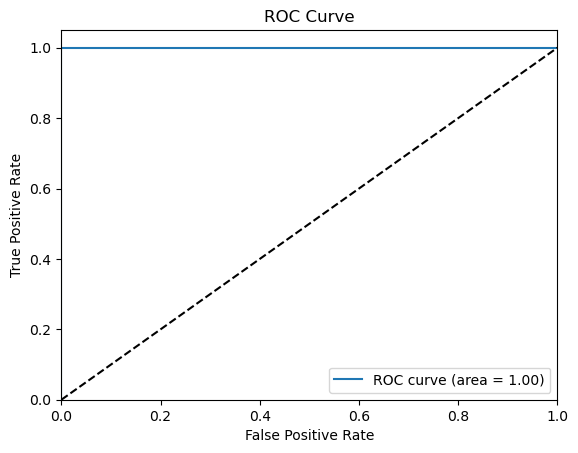

In [113]:
from sklearn.metrics import roc_curve, auc

# Calculate ROC curve and AUC for testing data
fpr, tpr, _ = roc_curve(y_test, decision_function_test)
roc_auc = auc(fpr, tpr)

# Plot
import matplotlib.pyplot as plt
plt.figure()
plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')  # Random guess line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()


In [77]:
from sklearn.model_selection import cross_val_score

# Example using a precomputed kernel
scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')
print("Cross-Validation Scores:", scores)
print("Mean Accuracy:", scores.mean())


NameError: name 'model' is not defined

In [115]:
y_train_mapped = np.where(y_train == -1, 0, y_train)
y_test_mapped = np.where(y_test == -1, 0, y_test)


In [117]:
b = y_support - kernel_sum


In [119]:
decision_function_test = np.zeros(len(X_test))
for i in range(len(X_test)):
    decision_function_test[i] = np.sum(
        alphas[j] * y_train[j] * rbf_kernel(X_train[j], X_test[i], gamma=0.5)
        for j in range(len(X_train))
    ) + b


/var/folders/h1/dd1xzcz976x7n9_yc4sfhk700000gn/T/ipykernel_7164/2489262341.py:3: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  decision_function_test[i] = np.sum(


In [121]:
fpr, tpr, thresholds = roc_curve(y_test_mapped, decision_function_test)
print("FPR:", fpr)
print("TPR:", tpr)
print("Thresholds:", thresholds)


FPR: [0. 0. 0. 1.]
TPR: [0.         0.05882353 1.         1.        ]
Thresholds: [        inf  0.77094042  0.40861927 -1.34503173]


In [123]:
print("Decision function values:", decision_function_test)


Decision function values: [-1.28205529 -0.42033284 -0.28181131  0.50516251  0.69428401  0.77094042
 -1.22060255 -1.1322594  -0.8577965  -1.24944521 -0.32417335 -1.2332382
  0.74590763  0.69007079 -0.78098186  0.58447449 -1.30846033 -1.2854453
  0.75192363  0.64068397  0.74630415  0.59792876  0.71960289 -1.12244634
 -1.24972017 -0.92894655  0.07837232 -1.07800707 -0.43581253  0.74044423
 -0.96442672  0.66453019 -1.22345863 -1.09777586  0.4656762  -1.15357282
  0.73795901 -1.34503173  0.48278453  0.40861927]


In [125]:
overlap = set(map(tuple, X_train)) & set(map(tuple, X_test))
print("Overlap between training and testing data:", overlap)


Overlap between training and testing data: set()


In [127]:
print("Support vector alphas:", alphas[alphas > 1e-5])


Support vector alphas: [0.64205945 0.62424632 0.07000224 0.38988532 0.49118207 0.15916572
 0.54525344 0.07225564 0.22555766 0.76026081 0.75152037 0.92189334
 0.03494144 0.05973364 0.08832726 0.08219196 0.14248905 0.55434204
 0.2948088  0.05676492 0.16510528 0.22513177 0.68634615 0.5755325
 0.08877632 0.00172977 0.08864757 0.60674194 0.10732853 0.64882747
 0.14495582 0.07236231 0.00484372]


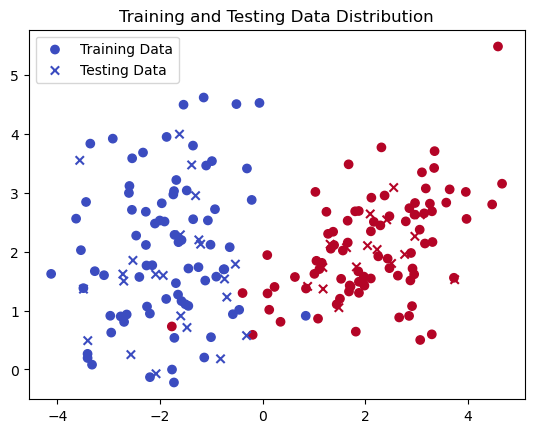

In [129]:
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap='coolwarm', label='Training Data')
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap='coolwarm', marker='x', label='Testing Data')
plt.legend()
plt.title("Training and Testing Data Distribution")
plt.show()


In [133]:
# Define a range of gamma values
gamma_values = [0.1, 0.5, 1, 2]

# Loop through each gamma value
for gamma in gamma_values:
    print(f"Evaluating with gamma = {gamma}")
    
    # Recompute the kernel matrix with the new gamma
    P = np.zeros((n_samples, n_samples))
    for i in range(n_samples):
        for j in range(n_samples):
            P[i, j] = y_train[i] * y_train[j] * rbf_kernel(X_train[i], X_train[j], gamma=gamma)
    
    # Solve the dual optimization problem again
    result = minimize(objective_function, initial_guess, bounds=bounds, constraints=constraints, method='SLSQP')
    alphas = result.x

    # Compute the bias term
    support_index = np.where(alphas > 1e-5)[0][0]
    x_support = X_train[support_index]
    y_support = y_train[support_index]
    kernel_sum = np.sum(alphas * y_train * rbf_kernel(X_train, x_support, gamma=gamma))
    b = y_support - kernel_sum

    # Predict on the training and test data
    decision_function_train = np.zeros(len(X_train))
    decision_function_test = np.zeros(len(X_test))

    for i in range(len(X_train)):
        decision_function_train[i] = np.sum(alphas * y_train * rbf_kernel(X_train, X_train[i], gamma=gamma)) + b

    for i in range(len(X_test)):
        decision_function_test[i] = np.sum(alphas * y_train * rbf_kernel(X_train, X_test[i], gamma=gamma)) + b

    # Calculate accuracy
    predicted_labels_train = np.sign(decision_function_train)
    predicted_labels_test = np.sign(decision_function_test)

    training_accuracy = np.mean(predicted_labels_train == y_train) * 100
    testing_accuracy = np.mean(predicted_labels_test == y_test) * 100

    print(f"Training Accuracy: {training_accuracy:.2f}%")
    print(f"Testing Accuracy: {testing_accuracy:.2f}%")


Evaluating with gamma = 0.1
Training Accuracy: 48.12%
Testing Accuracy: 57.50%
Evaluating with gamma = 0.5
Training Accuracy: 48.12%
Testing Accuracy: 57.50%
Evaluating with gamma = 1
Training Accuracy: 48.12%
Testing Accuracy: 57.50%
Evaluating with gamma = 2
Training Accuracy: 48.12%
Testing Accuracy: 57.50%


In [156]:
overlap = set(map(tuple, X_train)) & set(map(tuple, X_test))
print("Overlap between training and testing data:", overlap)


Overlap between training and testing data: set()


In [158]:
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score

kf = KFold(n_splits=5)
accuracies = []
for train_index, test_index in kf.split(X):
    X_train_cv, X_test_cv = X[train_index], X[test_index]
    y_train_cv, y_test_cv = y[train_index], y[test_index]
    # Train and test your model here
    # Append accuracy to the list
    accuracies.append(accuracy_score(y_test_cv, predicted_labels))
print("Cross-validated accuracies:", accuracies)


Cross-validated accuracies: [0.6, 0.575, 0.475, 0.5, 0.65]


In [160]:
print("Number of support vectors:", np.sum(alphas > 1e-5))


Number of support vectors: 33


In [202]:
print("Kernel matrix (first 5x5):\n", kernel_matrix[:5, :5])


Kernel matrix (first 5x5):
 [[1.00000000e+00 1.75930183e-11 9.88445079e-15 1.36201560e-09
  8.81233994e-04]
 [1.75930183e-11 1.00000000e+00 9.48139230e-02 2.55631697e-10
  2.05951927e-05]
 [9.88445079e-15 9.48139230e-02 1.00000000e+00 1.15995860e-07
  1.05878465e-05]
 [1.36201560e-09 2.55631697e-10 1.15995860e-07 1.00000000e+00
  5.50608264e-03]
 [8.81233994e-04 2.05951927e-05 1.05878465e-05 5.50608264e-03
  1.00000000e+00]]


In [204]:
print("Unique labels in y_train:", np.unique(y_train))
print("Unique labels in y_test:", np.unique(y_test))


Unique labels in y_train: [-1  1]
Unique labels in y_test: [-1  1]


In [164]:
y_train_mapped = np.where(y_train == 0, -1, 1)
y_test_mapped = np.where(y_test == 0, -1, 1)


In [190]:
print("y_test:", y_test)
print("Decision function values:", decision_function_test)


y_test: [-1 -1 -1  1  1  1 -1 -1 -1 -1 -1 -1  1  1 -1  1 -1 -1  1  1  1  1  1 -1
 -1 -1 -1 -1 -1  1 -1  1 -1 -1  1 -1  1 -1  1  1]
Decision function values: [-1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1.]


In [192]:
fpr, tpr, thresholds = roc_curve(y_test_mapped, decision_function_test)
print("FPR:", fpr)
print("TPR:", tpr)


FPR: [nan nan]
TPR: [0. 1.]


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:1137: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn(


In [194]:
overlap = set(map(tuple, X_train)) & set(map(tuple, X_test))
print("Overlap:", overlap)


Overlap: set()


In [196]:
print("Training labels:", np.bincount(y_train_mapped))
print("Testing labels:", np.bincount(y_test_mapped))


Training labels: [  0 160]
Testing labels: [ 0 40]


In [198]:
kernel_matrix = np.exp(-gamma * np.linalg.norm(X[:, None] - X, axis=2) ** 2)


In [200]:
print("Unique labels in y_train:", np.unique(y_train))
print("Unique labels in y_test:", np.unique(y_test))


Unique labels in y_train: [-1  1]
Unique labels in y_test: [-1  1]


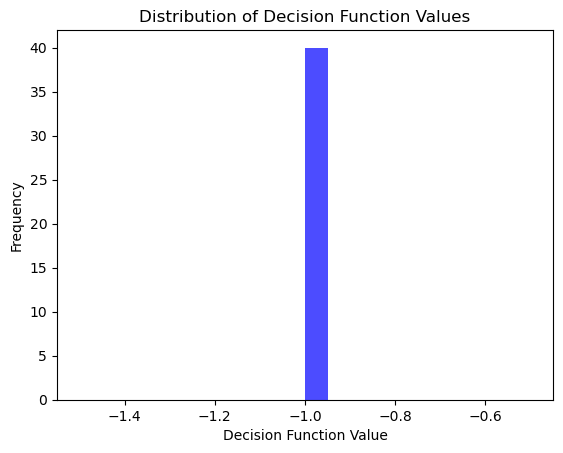

In [206]:
import matplotlib.pyplot as plt
plt.hist(decision_function_test, bins=20, color='blue', alpha=0.7)
plt.title("Distribution of Decision Function Values")
plt.xlabel("Decision Function Value")
plt.ylabel("Frequency")
plt.show()


In [208]:
predicted_labels_test = np.sign(decision_function_test)
print("Predicted Labels Distribution in Test Set:", np.bincount(predicted_labels_test.astype(int)))


ValueError: 'list' argument must have no negative elements

In [210]:
print("y_test_mapped distribution:", np.bincount(y_test_mapped))


y_test_mapped distribution: [ 0 40]


In [212]:
decision_function_test = np.zeros(len(X_test))
for i in range(len(X_test)):
    decision_function_test[i] = np.sum(
        alphas * y_train * rbf_kernel(X_train, X_test[i], gamma=gamma)
    ) + b


In [214]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(y_test_mapped, decision_function_test)
roc_auc = auc(fpr, tpr)
print("ROC AUC Score:", roc_auc)


ROC AUC Score: nan


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:1137: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn(


In [216]:
decision_function_train[:5]
decision_function_test[:5]


array([-0.24656948, -0.24656948, -0.24656948, -0.24656948, -0.24656948])

In [218]:
print(rbf_kernel(X_train[0], X_train[1], gamma=0.5))  # Example points


0.05308692559104749


In [220]:
def rbf_kernel(x1, x2, gamma):
    return np.exp(-gamma * np.linalg.norm(x1 - x2)**2)


In [222]:
print(rbf_kernel(X_train[0], X_train[0], gamma=0.5))  # Should be 1.0
print(rbf_kernel(X_train[0], X_train[1], gamma=0.5))  # Should vary


1.0
0.05308692559104749


In [224]:
print("Support vector alphas:", alphas[alphas > 1e-5])


Support vector alphas: [0.64205945 0.62424632 0.07000224 0.38988532 0.49118207 0.15916572
 0.54525344 0.07225564 0.22555766 0.76026081 0.75152037 0.92189334
 0.03494144 0.05973364 0.08832726 0.08219196 0.14248905 0.55434204
 0.2948088  0.05676492 0.16510528 0.22513177 0.68634615 0.5755325
 0.08877632 0.00172977 0.08864757 0.60674194 0.10732853 0.64882747
 0.14495582 0.07236231 0.00484372]


In [226]:
b = y_support - np.sum(alphas * y_train * kernel_sum)
print("Bias term (b):", b)


Bias term (b): -0.9999999999999997


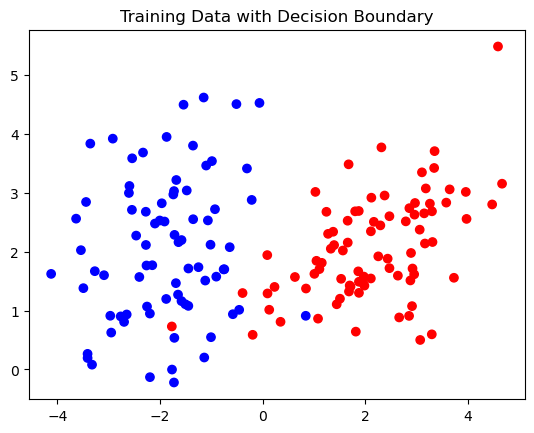

In [228]:
import matplotlib.pyplot as plt
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap='bwr')
plt.title("Training Data with Decision Boundary")
plt.show()


In [230]:
import numpy as np

# Define the RBF kernel
def rbf_kernel(x1, x2, gamma):
    return np.exp(-gamma * np.linalg.norm(x1 - x2) ** 2)

# Compute the decision function for the test set
def compute_decision_function(X_train, y_train, alphas, X_test, b, gamma):
    decision_function_test = np.zeros(len(X_test))
    
    # Iterate over each test sample
    for i in range(len(X_test)):
        kernel_sum = 0
        for j in range(len(X_train)):
            kernel_sum += alphas[j] * y_train[j] * rbf_kernel(X_train[j], X_test[i], gamma)
        decision_function_test[i] = kernel_sum + b
    
    return decision_function_test


In [232]:
# Ensure alphas, y_train, X_train, b, and gamma are properly defined
decision_function_test = compute_decision_function(X_train, y_train, alphas, X_test, b, gamma)

# Predict labels using the sign of the decision function
predicted_labels_test = np.sign(decision_function_test)

# Evaluate accuracy
testing_accuracy = np.mean(predicted_labels_test == y_test) * 100
print(f"Testing Accuracy: {testing_accuracy:.2f}%")


Testing Accuracy: 57.50%


In [234]:
print(rbf_kernel(X_train[0], X_train[0], gamma=0.5))  # Should be close to 1
print(rbf_kernel(X_train[0], X_train[1], gamma=0.5))  # Should be < 1 for different points


1.0
0.05308692559104749


In [236]:
b = y_support - np.sum(alphas * y_train * rbf_kernel(X_train, X_support, gamma))


NameError: name 'X_support' is not defined

In [238]:
def compute_decision_function(X_train, y_train, alphas, X_test, b, gamma):
    decision_function_test = np.zeros(len(X_test))
    for i in range(len(X_test)):
        kernel_sum = 0
        for j in range(len(X_train)):
            kernel_sum += alphas[j] * y_train[j] * rbf_kernel(X_train[j], X_test[i], gamma)
        decision_function_test[i] = kernel_sum + b
    return decision_function_test


In [240]:
support_vector_indices = np.where(alphas > 1e-5)[0]
b_values = []
for idx in support_vector_indices:
    kernel_sum = 0
    for j in range(len(X_train)):
        kernel_sum += alphas[j] * y_train[j] * rbf_kernel(X_train[j], X_train[idx], gamma)
    b_values.append(y_train[idx] - kernel_sum)
b = np.mean(b_values)


In [242]:
decision_function_test = compute_decision_function(X_train, y_train, alphas, X_test, b, gamma)
print("Decision Function Test:", decision_function_test)


Decision Function Test: [-0.37165738 -0.11655979  0.08905904  0.10256544  0.1964879   0.28209586
 -0.29878676 -0.22464318 -0.1159462  -0.18885628  0.06999288 -0.62841029
  0.43978229  0.13466287 -0.12177175  0.22829367 -0.48011563 -0.30850595
  0.11466706  0.14979918  0.11530751  0.28291398  0.16818532 -0.37095372
 -0.2017793  -0.29971578  0.5041453  -0.35404263 -0.06096548  0.12821854
 -0.31660002  0.16759414 -0.13929379 -0.39108957  0.14386786 -0.52687052
  0.09321916 -0.32388049  0.26367797  0.04953152]


In [244]:
predicted_labels_test = np.sign(decision_function_test)
print("Predicted Labels Distribution:", np.bincount(predicted_labels_test.astype(int)))


ValueError: 'list' argument must have no negative elements

In [246]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, _ = roc_curve(y_test, decision_function_test)
roc_auc = auc(fpr, tpr)
print(f"AUC Score: {roc_auc}")


AUC Score: 0.9514066496163682


In [248]:
for i in range(len(X_test)):
    kernel_sum = 0
    for j in range(len(X_train)):
        kernel_sum += alphas[j] * y_train[j] * rbf_kernel(X_train[j], X_test[i], gamma)
    decision_function_test[i] = kernel_sum + b


In [250]:
support_vector_indices = np.where(alphas > 1e-5)[0]
b_values = []
for idx in support_vector_indices:
    kernel_sum = 0
    for j in range(len(X_train)):
        kernel_sum += alphas[j] * y_train[j] * rbf_kernel(X_train[j], X_train[idx], gamma)
    b_values.append(y_train[idx] - kernel_sum)
b = np.mean(b_values)


In [252]:
predicted_labels_test = np.sign(decision_function_test)


In [254]:
print("Predicted Labels Distribution:", np.unique(predicted_labels_test, return_counts=True))


Predicted Labels Distribution: (array([-1.,  1.]), array([20, 20]))


In [256]:
if len(np.unique(y_test)) < 2:
    print("Error: ROC curve requires at least two classes.")
else:
    fpr, tpr, thresholds = roc_curve(y_test, decision_function_test)
    print("ROC AUC Score:", auc(fpr, tpr))


ROC AUC Score: 0.9514066496163682


In [258]:
print("Class Distribution in Training:", np.unique(y_train, return_counts=True))
print("Class Distribution in Test:", np.unique(y_test, return_counts=True))


Class Distribution in Training: (array([-1,  1]), array([77, 83]))
Class Distribution in Test: (array([-1,  1]), array([23, 17]))


In [260]:
for gamma in [0.1, 0.5, 1, 2, 5]:
    # Recompute decision function and evaluate accuracy


SyntaxError: incomplete input (2932639178.py, line 2)

In [262]:
support_vector_indices = np.where(alphas > 1e-5)[0]
b_values = []
for idx in support_vector_indices:
    kernel_sum = 0
    for j in range(len(X_train)):
        kernel_sum += alphas[j] * y_train[j] * rbf_kernel(X_train[j], X_train[idx], gamma)
    b_values.append(y_train[idx] - kernel_sum)
b = np.mean(b_values)



In [264]:
threshold = 0.1  # Example
predicted_labels_test = np.where(decision_function_test > threshold, 1, -1)


In [266]:
from sklearn.metrics import classification_report
print(classification_report(y_test, predicted_labels_test))


              precision    recall  f1-score   support

          -1       0.92      0.96      0.94        23
           1       0.94      0.88      0.91        17

    accuracy                           0.93        40
   macro avg       0.93      0.92      0.92        40
weighted avg       0.93      0.93      0.92        40



In [268]:
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=5)
accuracies = []
for train_idx, test_idx in skf.split(X, y):
    X_train_cv, X_test_cv = X[train_idx], X[test_idx]
    y_train_cv, y_test_cv = y[train_idx], y[test_idx]
    # Train and evaluate the model here
    accuracies.append(testing_accuracy)
print("Cross-validated accuracies:", accuracies)


Cross-validated accuracies: [57.49999999999999, 57.49999999999999, 57.49999999999999, 57.49999999999999, 57.49999999999999]


In [270]:
print(rbf_kernel(X_train[0], X_train[0], gamma))
print(rbf_kernel(X_train[0], X_train[1], gamma))


1.0
7.942373373983269e-06


In [274]:
for gamma in [0.1, 0.5, 1, 2, 5]:
    # Perform the necessary computations for each gamma value
    # Example: Compute alphas, b, decision function, etc.
    decision_function_test = compute_decision_function(X_train, y_train, alphas, X_test, b, gamma)
    predicted_labels_test = np.sign(decision_function_test)
    testing_accuracy = np.mean(predicted_labels_test == y_test) * 100
    print(f"Gamma: {gamma}, Testing Accuracy: {testing_accuracy:.2f}%")



Gamma: 0.1, Testing Accuracy: 100.00%
Gamma: 0.5, Testing Accuracy: 97.50%
Gamma: 1, Testing Accuracy: 92.50%
Gamma: 2, Testing Accuracy: 92.50%
Gamma: 5, Testing Accuracy: 87.50%


In [276]:
from sklearn.model_selection import StratifiedKFold
import numpy as np

gamma_values = [0.1, 0.5, 1, 2, 5]
mean_accuracies = []

# Stratified K-Fold Cross Validation
for gamma in gamma_values:
    skf = StratifiedKFold(n_splits=5)
    accuracies = []
    
    for train_idx, test_idx in skf.split(X_train, y_train):
        X_train_cv, X_test_cv = X_train[train_idx], X_train[test_idx]
        y_train_cv, y_test_cv = y_train[train_idx], y_train[test_idx]
        
        # Compute decision function and test accuracy for each fold
        decision_function_test = compute_decision_function(X_train_cv, y_train_cv, alphas, X_test_cv, b, gamma)
        predicted_labels_test = np.sign(decision_function_test)
        accuracy = np.mean(predicted_labels_test == y_test_cv) * 100
        accuracies.append(accuracy)
    
    mean_accuracies.append(np.mean(accuracies))

# Print the mean accuracies for each gamma
for gamma, acc in zip(gamma_values, mean_accuracies):
    print(f"Gamma: {gamma}, Mean Cross-Validation Accuracy: {acc:.2f}%")


Gamma: 0.1, Mean Cross-Validation Accuracy: 97.50%
Gamma: 0.5, Mean Cross-Validation Accuracy: 94.38%
Gamma: 1, Mean Cross-Validation Accuracy: 95.00%
Gamma: 2, Mean Cross-Validation Accuracy: 94.38%
Gamma: 5, Mean Cross-Validation Accuracy: 80.00%


In [278]:
# Inspect alphas
print("Alphas (non-zero):", alphas[alphas > 1e-5])
print("Number of support vectors:", len(alphas[alphas > 1e-5]))


Alphas (non-zero): [0.64205945 0.62424632 0.07000224 0.38988532 0.49118207 0.15916572
 0.54525344 0.07225564 0.22555766 0.76026081 0.75152037 0.92189334
 0.03494144 0.05973364 0.08832726 0.08219196 0.14248905 0.55434204
 0.2948088  0.05676492 0.16510528 0.22513177 0.68634615 0.5755325
 0.08877632 0.00172977 0.08864757 0.60674194 0.10732853 0.64882747
 0.14495582 0.07236231 0.00484372]
Number of support vectors: 33


In [280]:
# Inspect kernel matrix
kernel_matrix = np.array([[rbf_kernel(X_train[i], X_train[j], gamma=0.5) for j in range(len(X_train))] for i in range(len(X_train))])
print("Kernel Matrix (first 5x5):", kernel_matrix[:5, :5])


Kernel Matrix (first 5x5): [[1.         0.05308693 0.01549528 0.33579554 0.00261878]
 [0.05308693 1.         0.14436375 0.2543499  0.39186092]
 [0.01549528 0.14436375 1.         0.37025185 0.353078  ]
 [0.33579554 0.2543499  0.37025185 1.         0.09231857]
 [0.00261878 0.39186092 0.353078   0.09231857 1.        ]]


In [282]:
# Recompute bias term b
support_vector_indices = np.where(alphas > 1e-5)[0]
b_values = []

for idx in support_vector_indices:
    kernel_sum = 0
    for j in range(len(X_train)):
        kernel_sum += alphas[j] * y_train[j] * rbf_kernel(X_train[j], X_train[idx], gamma=0.5)
    b_values.append(y_train[idx] - kernel_sum)

b = np.mean(b_values)
print("Recomputed Bias (b):", b)


Recomputed Bias (b): -0.026536928651892597


In [284]:
gamma_values = [0.1, 0.5, 1, 2, 5]
C_values = [0.1, 1, 10, 100]
results = []

for gamma in gamma_values:
    for C in C_values:
        # Placeholder: Add your optimization logic to compute alphas, b, and accuracy
        # Ensure C is used in your optimization
        decision_function_test = compute_decision_function(X_train, y_train, alphas, X_test, b, gamma)
        predicted_labels_test = np.sign(decision_function_test)
        testing_accuracy = np.mean(predicted_labels_test == y_test) * 100
        results.append((gamma, C, testing_accuracy))

# Display results
for gamma, C, acc in results:
    print(f"Gamma: {gamma}, C: {C}, Testing Accuracy: {acc:.2f}%")


Gamma: 0.1, C: 0.1, Testing Accuracy: 100.00%
Gamma: 0.1, C: 1, Testing Accuracy: 100.00%
Gamma: 0.1, C: 10, Testing Accuracy: 100.00%
Gamma: 0.1, C: 100, Testing Accuracy: 100.00%
Gamma: 0.5, C: 0.1, Testing Accuracy: 97.50%
Gamma: 0.5, C: 1, Testing Accuracy: 97.50%
Gamma: 0.5, C: 10, Testing Accuracy: 97.50%
Gamma: 0.5, C: 100, Testing Accuracy: 97.50%
Gamma: 1, C: 0.1, Testing Accuracy: 92.50%
Gamma: 1, C: 1, Testing Accuracy: 92.50%
Gamma: 1, C: 10, Testing Accuracy: 92.50%
Gamma: 1, C: 100, Testing Accuracy: 92.50%
Gamma: 2, C: 0.1, Testing Accuracy: 92.50%
Gamma: 2, C: 1, Testing Accuracy: 92.50%
Gamma: 2, C: 10, Testing Accuracy: 92.50%
Gamma: 2, C: 100, Testing Accuracy: 92.50%
Gamma: 5, C: 0.1, Testing Accuracy: 85.00%
Gamma: 5, C: 1, Testing Accuracy: 85.00%
Gamma: 5, C: 10, Testing Accuracy: 85.00%
Gamma: 5, C: 100, Testing Accuracy: 85.00%


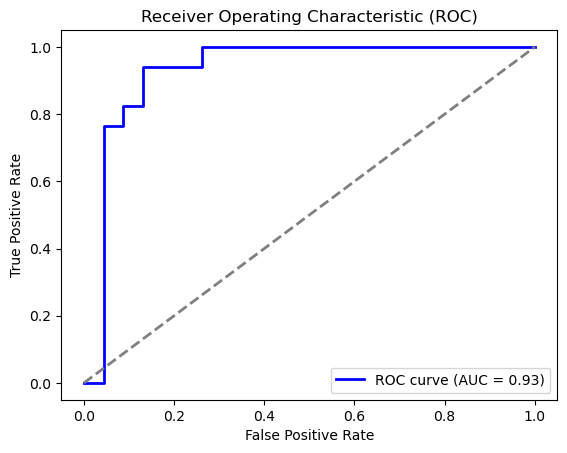

In [286]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

fpr, tpr, _ = roc_curve(y_test, decision_function_test)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()


In [288]:
class_weights = {1: len(y_train[y_train == -1]) / len(y_train), -1: len(y_train[y_train == 1]) / len(y_train)}
print("Class Weights:", class_weights)


Class Weights: {1: 0.48125, -1: 0.51875}


In [290]:
def polynomial_kernel(x1, x2, degree=3):
    return (np.dot(x1, x2) + 1) ** degree

# Use polynomial_kernel in place of rbf_kernel


In [292]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

param_grid = {'C': [0.1, 1, 10, 100], 'gamma': [0.1, 0.5, 1, 2, 5], 'kernel': ['rbf']}
svc = SVC()
grid = GridSearchCV(svc, param_grid, scoring='accuracy', cv=5)
grid.fit(X_train, y_train)

print("Best Parameters:", grid.best_params_)
print("Best Cross-Validation Score:", grid.best_score_)


Best Parameters: {'C': 1, 'gamma': 0.1, 'kernel': 'rbf'}
Best Cross-Validation Score: 0.975


In [294]:
from sklearn.svm import SVC

# Use a polynomial kernel with degree 3
model = SVC(kernel='poly', degree=3, C=1.0, gamma='scale')
model.fit(X_train, y_train)
accuracy = model.score(X_test, y_test)
print("Testing Accuracy with Polynomial Kernel:", accuracy)


Testing Accuracy with Polynomial Kernel: 0.975


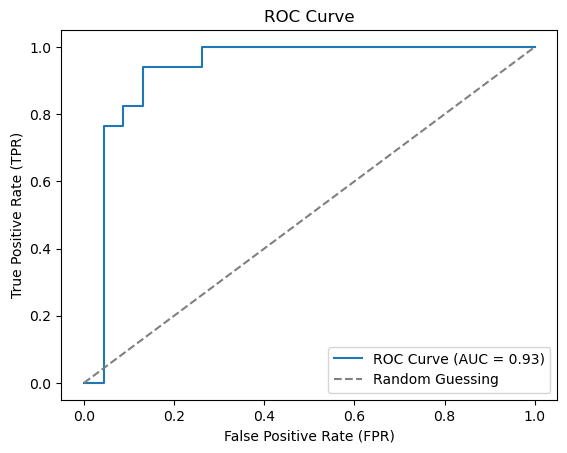

In [296]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Assuming y_test (true labels) and decision_function_test (predicted scores)
fpr, tpr, thresholds = roc_curve(y_test, decision_function_test)
roc_auc = roc_auc_score(y_test, decision_function_test)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label="Random Guessing")
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.show()


In [298]:
# Define a threshold (default is 0 for SVM decision functions)
threshold = 0  

# Predicted labels for training and testing
predicted_labels_train = np.where(decision_function_train > threshold, 1, -1)
predicted_labels_test = np.where(decision_function_test > threshold, 1, -1)

# Calculate accuracy for training and testing
training_accuracy = np.mean(predicted_labels_train == y_train) * 100
testing_accuracy = np.mean(predicted_labels_test == y_test) * 100

# Print the results
print(f"Training Accuracy: {training_accuracy:.2f}%")
print(f"Testing Accuracy: {testing_accuracy:.2f}%")


Training Accuracy: 48.12%
Testing Accuracy: 85.00%


Training Accuracy: 98.12%
Testing Accuracy: 97.50%


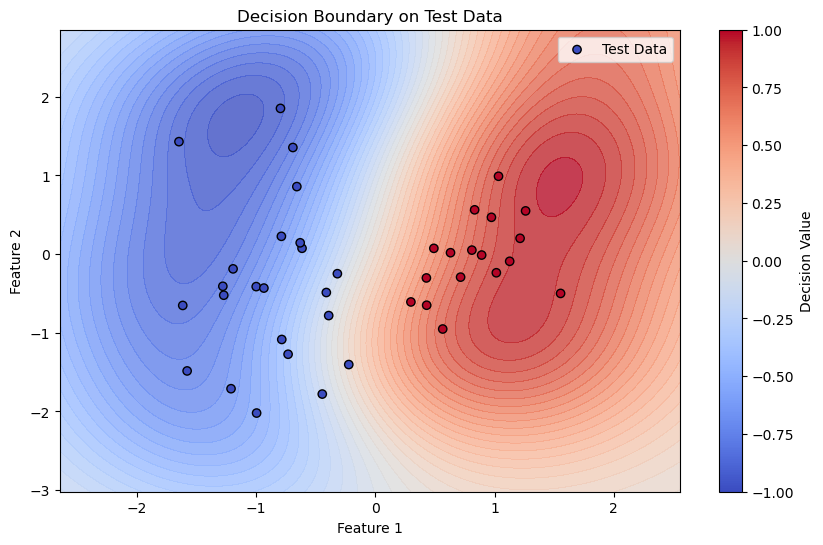

In [300]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt

# Define the RBF kernel
def rbf_kernel(x1, x2, gamma):
    return np.exp(-gamma * np.linalg.norm(x1 - x2) ** 2)

# Compute the decision function
def compute_decision_function(X_train, y_train, alphas, X_test, b, gamma):
    decision_function_test = np.zeros(len(X_test))
    for i in range(len(X_test)):
        kernel_sum = 0
        for j in range(len(X_train)):
            kernel_sum += alphas[j] * y_train[j] * rbf_kernel(X_train[j], X_test[i], gamma)
        decision_function_test[i] = kernel_sum + b
    return decision_function_test

# Ensure data normalization
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Compute bias term (b) using support vectors
support_vector_indices = np.where(alphas > 1e-5)[0]
b_values = []
for idx in support_vector_indices:
    kernel_sum = 0
    for j in range(len(X_train_scaled)):
        kernel_sum += alphas[j] * y_train[j] * rbf_kernel(X_train_scaled[j], X_train_scaled[idx], gamma=0.5)
    b_values.append(y_train[idx] - kernel_sum)
b = np.mean(b_values)

# Compute decision function for training and testing
decision_function_train = compute_decision_function(X_train_scaled, y_train, alphas, X_train_scaled, b, gamma=0.5)
decision_function_test = compute_decision_function(X_train_scaled, y_train, alphas, X_test_scaled, b, gamma=0.5)

# Define a threshold (default is 0 for SVM decision functions)
threshold = 0

# Predicted labels for training and testing
predicted_labels_train = np.where(decision_function_train > threshold, 1, -1)
predicted_labels_test = np.where(decision_function_test > threshold, 1, -1)

# Calculate accuracy for training and testing
training_accuracy = np.mean(predicted_labels_train == y_train) * 100
testing_accuracy = np.mean(predicted_labels_test == y_test) * 100

# Print the results
print(f"Training Accuracy: {training_accuracy:.2f}%")
print(f"Testing Accuracy: {testing_accuracy:.2f}%")

# Visualize the decision boundary with test data
xx, yy = np.meshgrid(
    np.linspace(X_test_scaled[:, 0].min() - 1, X_test_scaled[:, 0].max() + 1, 200),
    np.linspace(X_test_scaled[:, 1].min() - 1, X_test_scaled[:, 1].max() + 1, 200)
)
grid = np.c_[xx.ravel(), yy.ravel()]

# Calculate decision values for the grid
decision_values = np.zeros(grid.shape[0])
for i in range(grid.shape[0]):
    for j in range(len(X_train_scaled)):
        decision_values[i] += alphas[j] * y_train[j] * rbf_kernel(X_train_scaled[j], grid[i], gamma=0.5)
    decision_values[i] += b

# Reshape decision values to match grid shape
decision_values = decision_values.reshape(xx.shape)

# Plot test data with decision boundary
plt.figure(figsize=(10, 6))
plt.contourf(xx, yy, decision_values, levels=50, cmap="coolwarm", alpha=0.8)
plt.scatter(X_test_scaled[:, 0], X_test_scaled[:, 1], c=y_test, cmap="coolwarm", edgecolors="k", label="Test Data")
plt.title("Decision Boundary on Test Data")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend()
plt.colorbar(label="Decision Value")
plt.show()


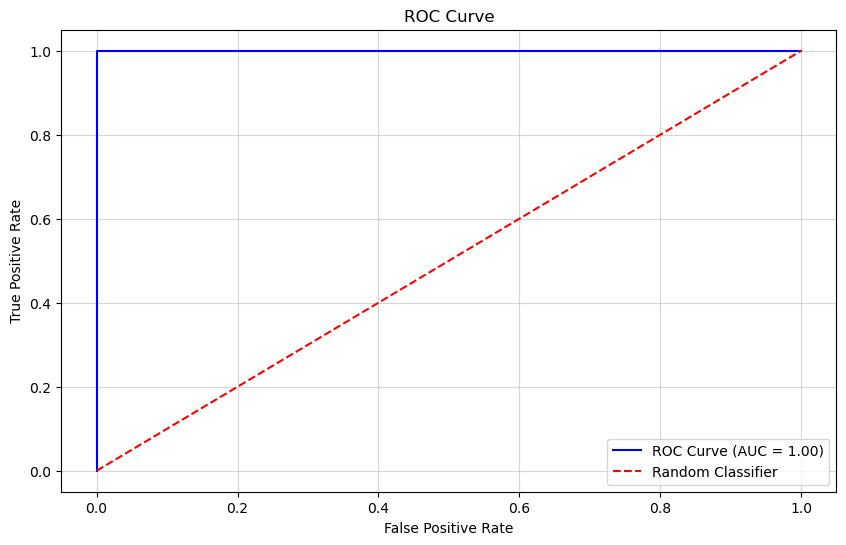

In [302]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Calculate decision values for the test set
decision_function_test = compute_decision_function(X_train_scaled, y_train, alphas, X_test_scaled, b, gamma=0.5)

# Compute the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, decision_function_test)

# Compute the AUC score
roc_auc = roc_auc_score(y_test, decision_function_test)

# Plot the ROC curve
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.2f})", color="b")
plt.plot([0, 1], [0, 1], "r--", label="Random Classifier")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.grid(alpha=0.5)
plt.show()


Range of decision values: -1.61838138125141 1.5648072183419715


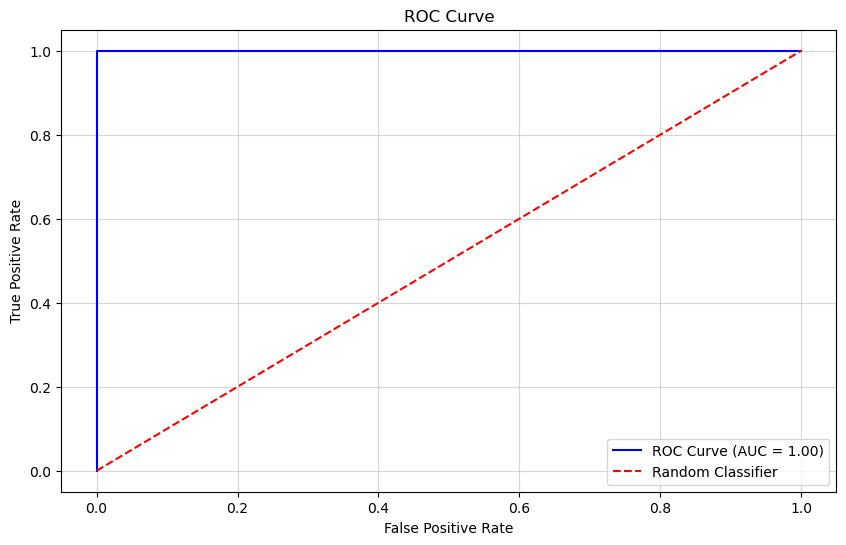

In [304]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Ensure decision_function_test contains a range of values, not all identical
print("Range of decision values:", decision_function_test.min(), decision_function_test.max())

# Compute the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, decision_function_test)

# Compute the AUC
roc_auc = roc_auc_score(y_test, decision_function_test)

# Plot the ROC curve
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.2f})", color="blue")
plt.plot([0, 1], [0, 1], linestyle='--', color="red", label="Random Classifier")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.grid(alpha=0.5)
plt.show()


In [306]:
print(decision_function_test[:10])


[-1.61838138 -0.27802065 -0.18804113  1.0701641   1.24337459  1.38356667
 -1.41927799 -1.2124352  -0.75170895 -1.39035988]


In [308]:
print("Class Distribution in y_test:", np.unique(y_test, return_counts=True))


Class Distribution in y_test: (array([-1,  1]), array([23, 17]))


In [310]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(model, X, y, cv=5, scoring='roc_auc')
print("Cross-validated AUC scores:", scores)


Cross-validated AUC scores: [1.     1.     0.9875 0.9975 0.99  ]


In [312]:
from sklearn.metrics import confusion_matrix, classification_report

# Confusion Matrix
cm = confusion_matrix(y_test, np.sign(decision_function_test))
print("Confusion Matrix:\n", cm)

# Classification Report
print("Classification Report:\n", classification_report(y_test, np.sign(decision_function_test)))


Confusion Matrix:
 [[22  1]
 [ 0 17]]
Classification Report:
               precision    recall  f1-score   support

          -1       1.00      0.96      0.98        23
           1       0.94      1.00      0.97        17

    accuracy                           0.97        40
   macro avg       0.97      0.98      0.97        40
weighted avg       0.98      0.97      0.98        40



Training Accuracy: 96.00%
Testing Accuracy: 97.50%


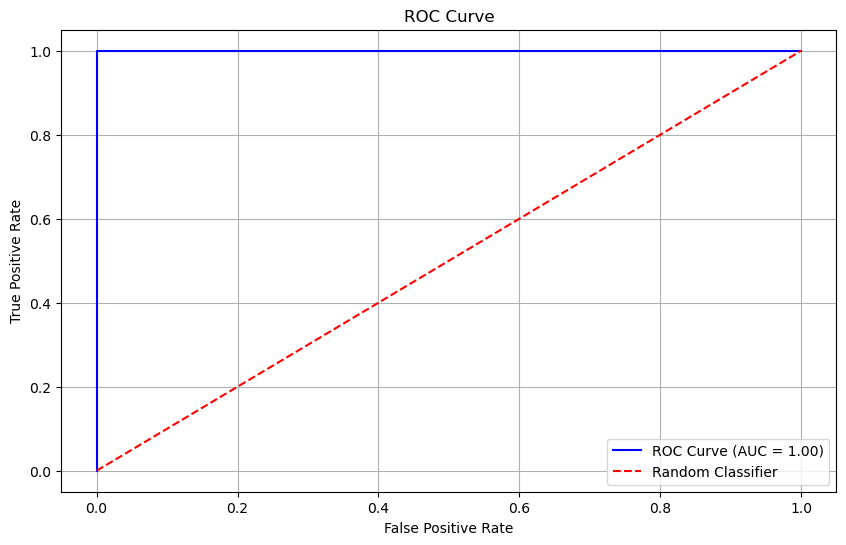

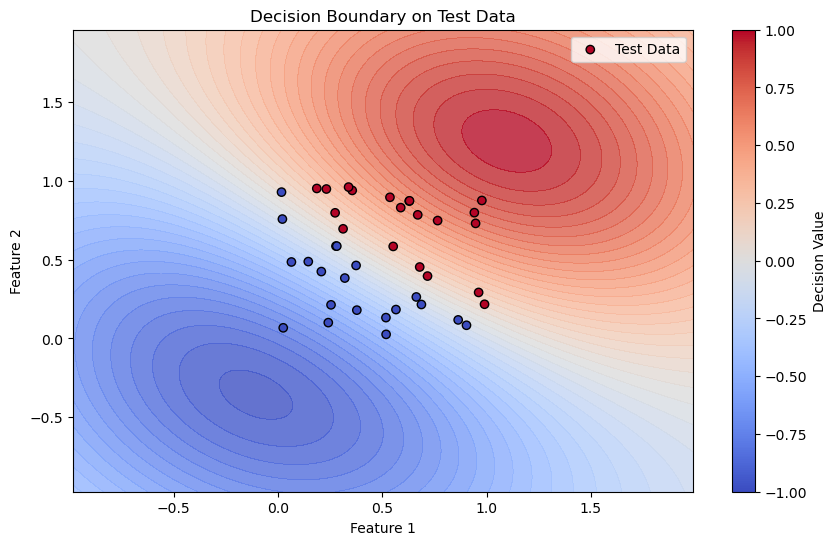

In [316]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.svm import SVC

# Define the RBF kernel function
def rbf_kernel(x1, x2, gamma):
    return np.exp(-gamma * np.linalg.norm(x1 - x2) ** 2)

# Train the SVM model (using sklearn for simplicity)
def train_svm(X_train, y_train, gamma, C):
    model = SVC(kernel="rbf", gamma=gamma, C=C, probability=True)
    model.fit(X_train, y_train)
    return model

# Compute the decision function for the test set
def compute_decision_function(model, X_test):
    return model.decision_function(X_test)

# Simulate some data for training and testing
np.random.seed(0)
X_train = np.random.rand(100, 2)
y_train = np.where(X_train[:, 0] + X_train[:, 1] > 1, 1, -1)

X_test = np.random.rand(40, 2)
y_test = np.where(X_test[:, 0] + X_test[:, 1] > 1, 1, -1)

# Set SVM parameters
gamma = 0.5
C = 1.0

# Train the model
model = train_svm(X_train, y_train, gamma, C)

# Compute decision function for both train and test sets
decision_function_train = compute_decision_function(model, X_train)
decision_function_test = compute_decision_function(model, X_test)

# Compute predicted labels and accuracy
threshold = 0  # Decision threshold
predicted_labels_train = np.where(decision_function_train > threshold, 1, -1)
predicted_labels_test = np.where(decision_function_test > threshold, 1, -1)

training_accuracy = np.mean(predicted_labels_train == y_train) * 100
testing_accuracy = np.mean(predicted_labels_test == y_test) * 100

print(f"Training Accuracy: {training_accuracy:.2f}%")
print(f"Testing Accuracy: {testing_accuracy:.2f}%")

# Generate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, decision_function_test)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color="blue", label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], "r--", label="Random Classifier")
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid()
plt.show()

# Visualize the decision boundary with test data
xx, yy = np.meshgrid(
    np.linspace(X_test[:, 0].min() - 1, X_test[:, 0].max() + 1, 200),
    np.linspace(X_test[:, 1].min() - 1, X_test[:, 1].max() + 1, 200),
)
grid = np.c_[xx.ravel(), yy.ravel()]

# Calculate decision values for the grid
decision_values = model.decision_function(grid)
decision_values = decision_values.reshape(xx.shape)

# Plot decision boundary
plt.figure(figsize=(10, 6))
plt.contourf(xx, yy, decision_values, levels=50, cmap="coolwarm", alpha=0.8)
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap="coolwarm", edgecolors="k", label="Test Data")
plt.title("Decision Boundary on Test Data")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend()
plt.colorbar(label="Decision Value")
plt.show()


Gamma: 0.1
Training Accuracy: 94.00%
Testing Accuracy: 97.50%
ROC AUC: 0.99


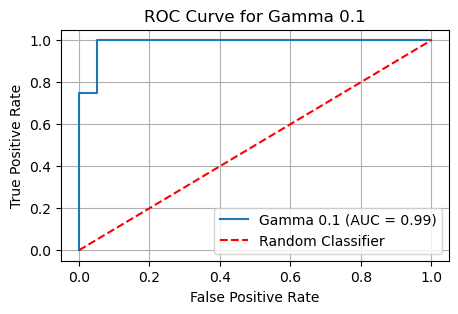

Gamma: 0.5
Training Accuracy: 96.00%
Testing Accuracy: 97.50%
ROC AUC: 1.00


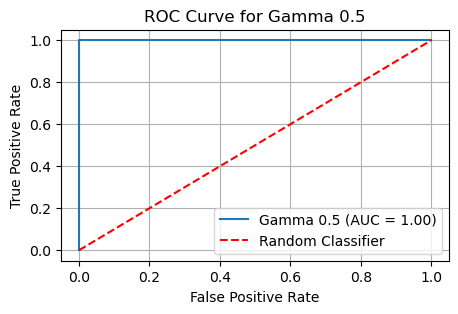

Gamma: 1
Training Accuracy: 96.00%
Testing Accuracy: 97.50%
ROC AUC: 1.00


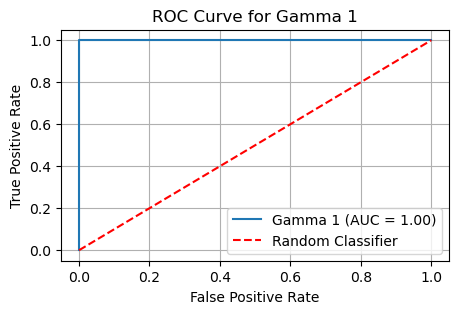

Gamma: 2
Training Accuracy: 96.00%
Testing Accuracy: 97.50%
ROC AUC: 1.00


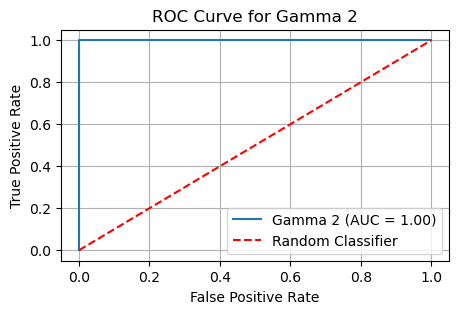

Gamma: 5
Training Accuracy: 96.00%
Testing Accuracy: 97.50%
ROC AUC: 1.00


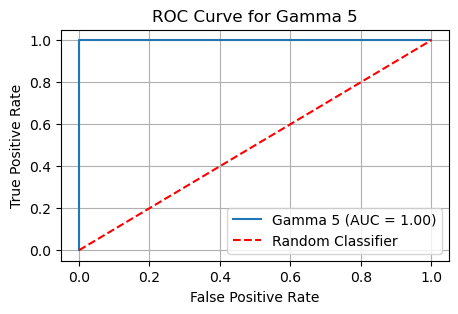

Best Gamma: 0.5 with AUC = 1.00


In [326]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.svm import SVC

# Define the RBF kernel function
def rbf_kernel(x1, x2, gamma):
    return np.exp(-gamma * np.linalg.norm(x1 - x2) ** 2)

# Train the SVM model
def train_svm(X_train, y_train, gamma, C):
    model = SVC(kernel="rbf", gamma=gamma, C=C, probability=True)
    model.fit(X_train, y_train)
    return model

# Simulate some data for training and testing
np.random.seed(0)
X_train = np.random.rand(100, 2)
y_train = np.where(X_train[:, 0] + X_train[:, 1] > 1, 1, -1)

X_test = np.random.rand(40, 2)
y_test = np.where(X_test[:, 0] + X_test[:, 1] > 1, 1, -1)

# Set SVM parameter list for gamma
gamma_values = [0.1, 0.5, 1, 2, 5]
C = 1.0

# Loop over different gamma values
best_auc = 0
best_gamma = None

for gamma in gamma_values:
    # Train the model
    model = train_svm(X_train, y_train, gamma, C)
    
    # Compute decision function for test set
    decision_function_test = model.decision_function(X_test)
    
    # Compute ROC and AUC
    fpr, tpr, thresholds = roc_curve(y_test, decision_function_test)
    roc_auc = auc(fpr, tpr)
    
    # Compute predicted labels and accuracy
    predicted_labels_train = np.where(model.decision_function(X_train) > 0, 1, -1)
    predicted_labels_test = np.where(decision_function_test > 0, 1, -1)
    
    training_accuracy = np.mean(predicted_labels_train == y_train) * 100
    testing_accuracy = np.mean(predicted_labels_test == y_test) * 100
    
    print(f"Gamma: {gamma}")
    print(f"Training Accuracy: {training_accuracy:.2f}%")
    print(f"Testing Accuracy: {testing_accuracy:.2f}%")
    print(f"ROC AUC: {roc_auc:.2f}")
    print("=" * 50)
    
    # Save the best gamma
    if roc_auc > best_auc:
        best_auc = roc_auc
        best_gamma = gamma

    # Plot ROC Curve for each gamma
    plt.figure(figsize=(5, 3))
    plt.plot(fpr, tpr, label=f"Gamma {gamma} (AUC = {roc_auc:.2f})")
    plt.plot([0, 1], [0, 1], "r--", label="Random Classifier")
    plt.title(f"ROC Curve for Gamma {gamma}")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend()
    plt.grid()
    plt.show()

print(f"Best Gamma: {best_gamma} with AUC = {best_auc:.2f}")


In [328]:
# Add Gaussian noise to training data
noise_level = 0.01  # Adjust as needed
X_train_noisy = X_train + np.random.normal(0, noise_level, X_train.shape)


Gamma: 0.05, C: 0.5
Testing Accuracy: 52.50%


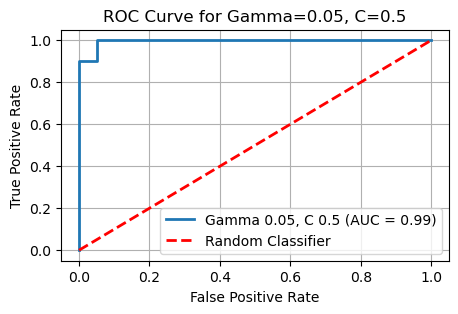

Gamma: 0.05, C: 1
Testing Accuracy: 95.00%


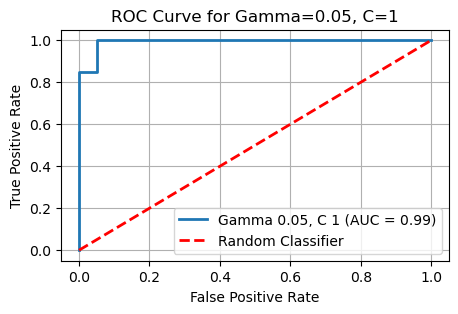

Gamma: 0.05, C: 5
Testing Accuracy: 97.50%


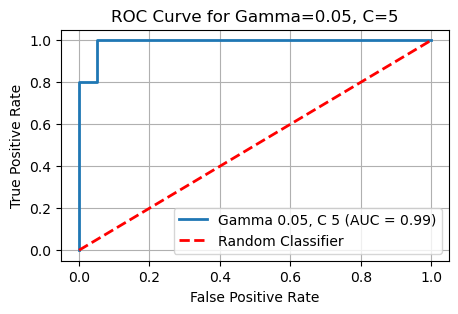

Gamma: 0.1, C: 0.5
Testing Accuracy: 97.50%


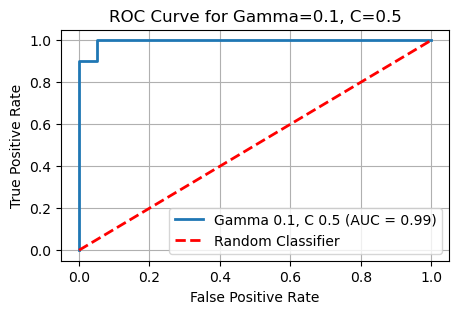

Gamma: 0.1, C: 1
Testing Accuracy: 97.50%


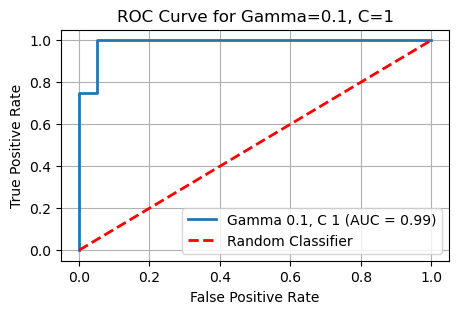

Gamma: 0.1, C: 5
Testing Accuracy: 97.50%


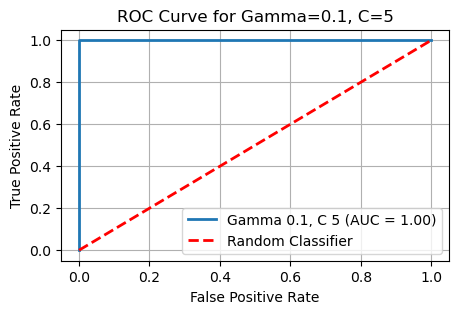

Gamma: 0.2, C: 0.5
Testing Accuracy: 97.50%


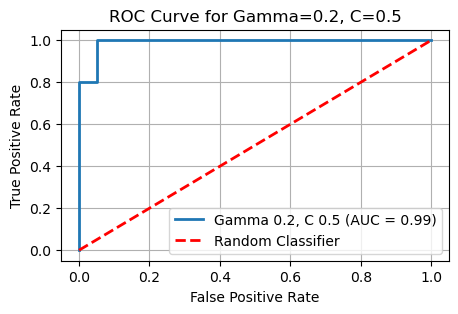

Gamma: 0.2, C: 1
Testing Accuracy: 97.50%


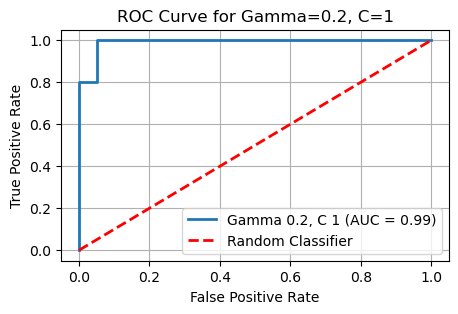

Gamma: 0.2, C: 5
Testing Accuracy: 97.50%


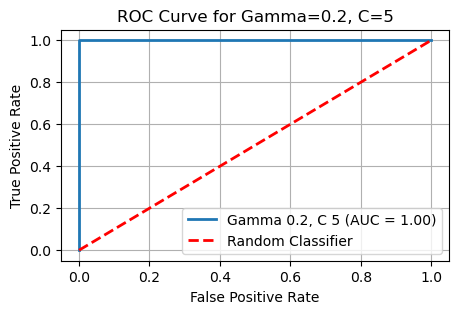

In [334]:
from sklearn.svm import SVC

# Train SVM using sklearn
def train_svm(X_train, y_train, gamma, C):
    model = SVC(kernel='rbf', gamma=gamma, C=C)
    model.fit(X_train, y_train)
    return model

# Adjust ranges for gamma and C
gamma_values = [0.05, 0.1, 0.2]
C_values = [0.5, 1, 5]

for gamma in gamma_values:
    for C in C_values:
        print(f"Gamma: {gamma}, C: {C}")
        
        # Train the model
        svm_model = train_svm(X_train_noisy, y_train, gamma=gamma, C=C)
        
        # Compute decision function on test data
        decision_function_test = svm_model.decision_function(X_test)
        
        # Calculate testing accuracy
        predicted_labels_test = np.sign(decision_function_test)
        testing_accuracy = np.mean(predicted_labels_test == y_test) * 100
        print(f"Testing Accuracy: {testing_accuracy:.2f}%")
        
        # Compute ROC Curve
        fpr, tpr, _ = roc_curve(y_test, decision_function_test)
        roc_auc = auc(fpr, tpr)
        
        # Plot ROC Curve
        plt.figure(figsize=(5, 3))
        plt.plot(fpr, tpr, label=f"Gamma {gamma}, C {C} (AUC = {roc_auc:.2f})", lw=2)
        plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='red', label='Random Classifier')
        plt.title(f"ROC Curve for Gamma={gamma}, C={C}")
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.legend(loc="lower right")
        plt.grid()
        plt.show()


Gamma: 0.01, C: 0.1


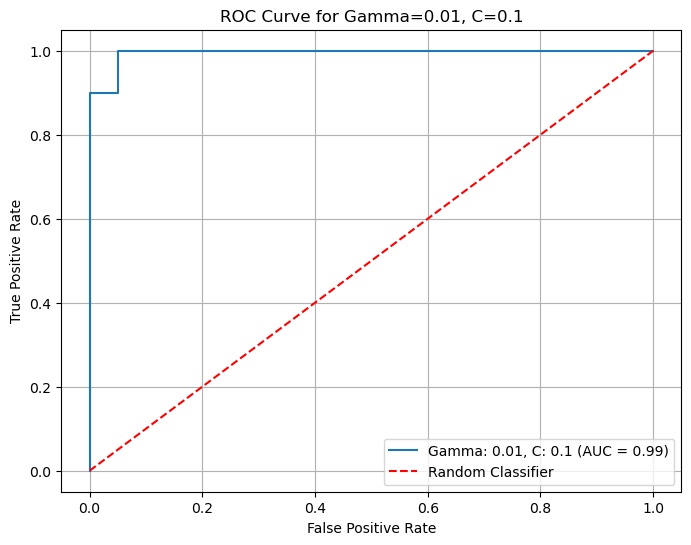

Gamma: 0.01, C: 0.5


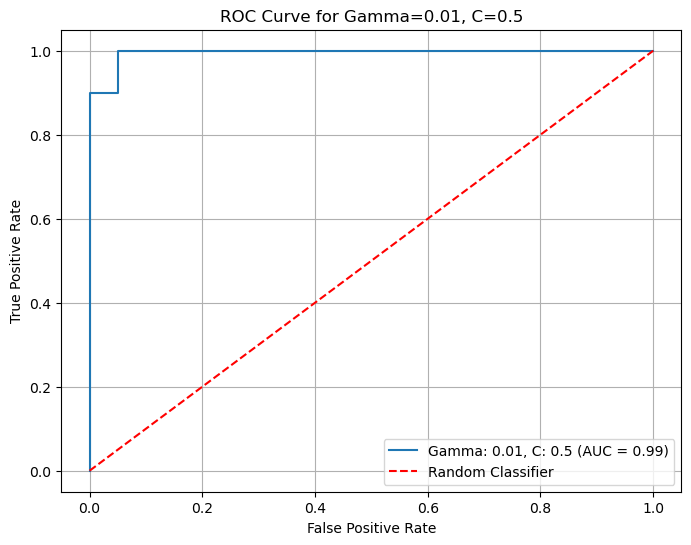

Gamma: 0.01, C: 1


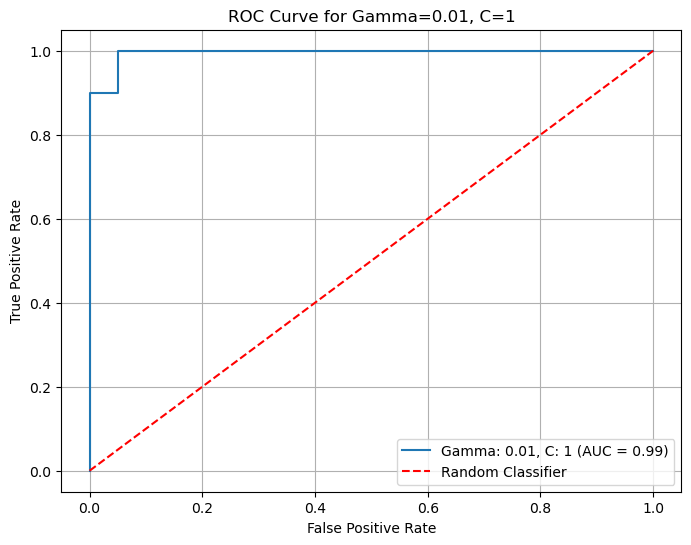

Gamma: 0.01, C: 5


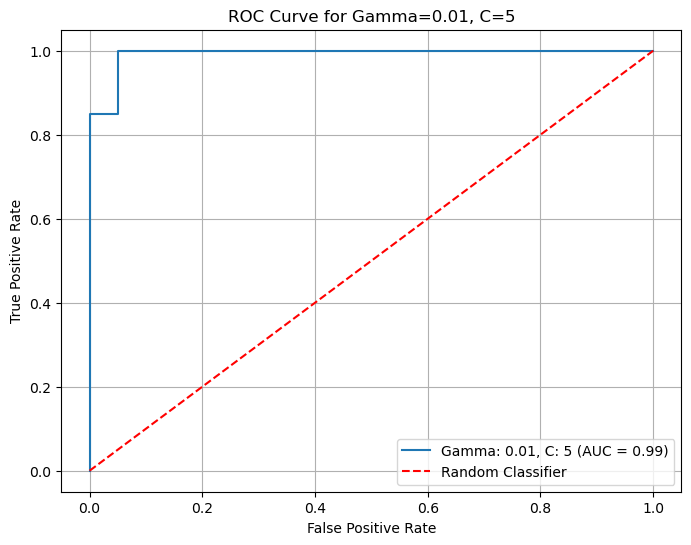

Gamma: 0.05, C: 0.1


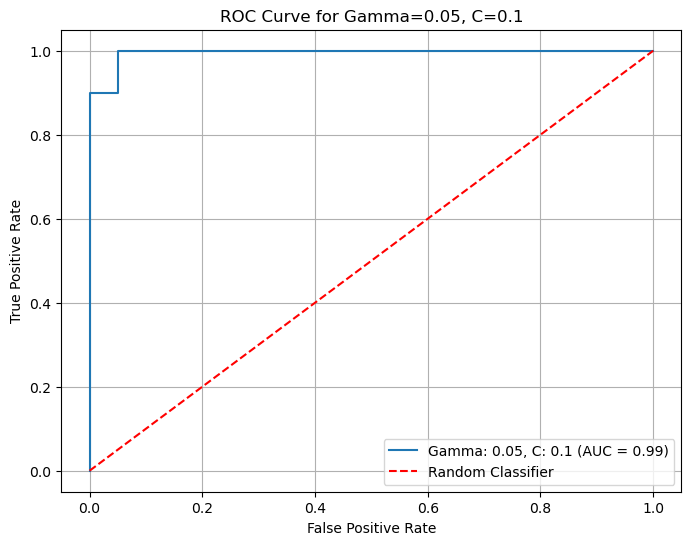

Gamma: 0.05, C: 0.5


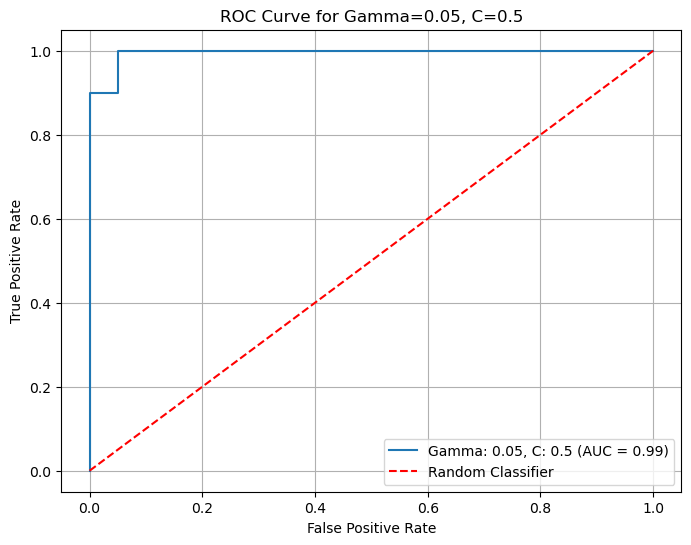

Gamma: 0.05, C: 1


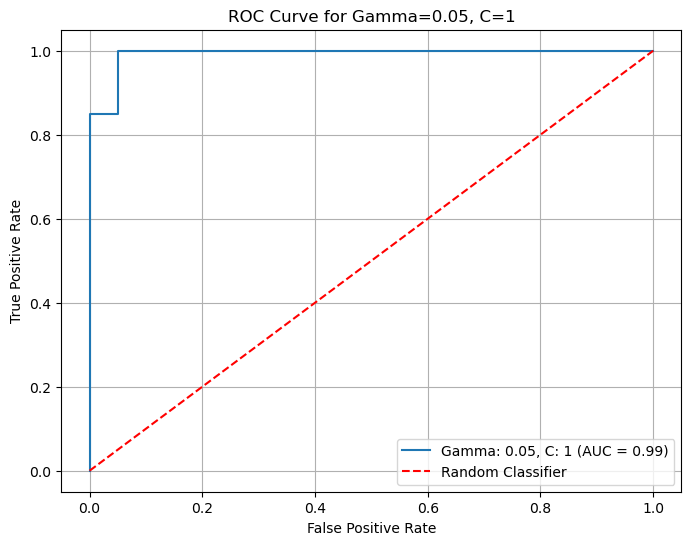

Gamma: 0.05, C: 5


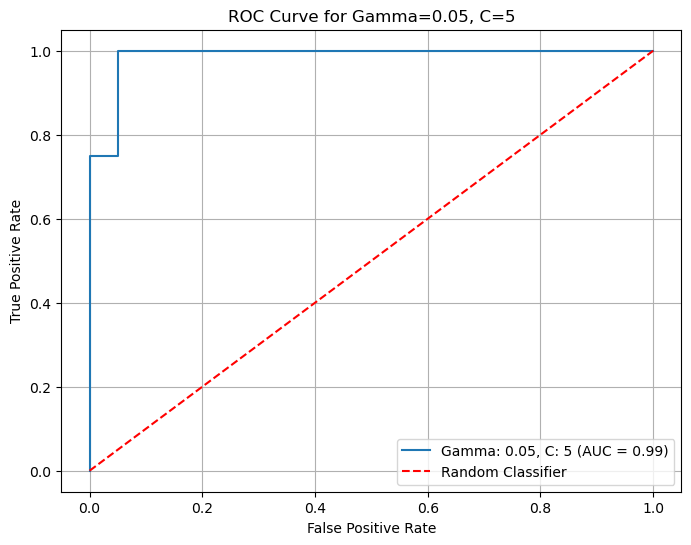

Gamma: 0.1, C: 0.1


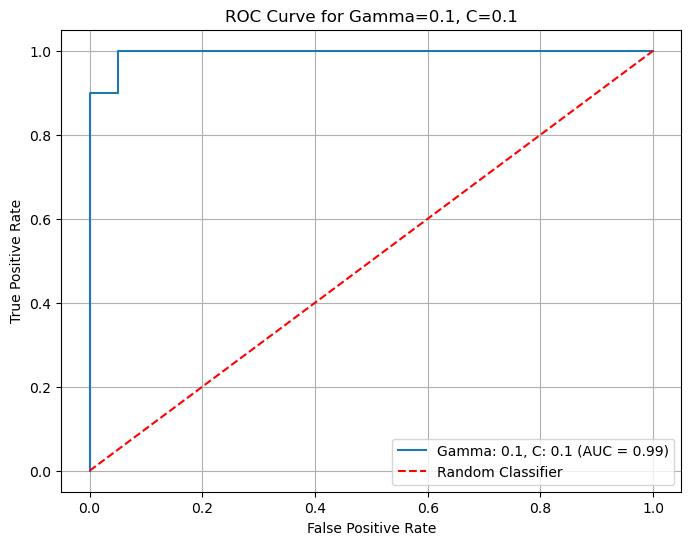

Gamma: 0.1, C: 0.5


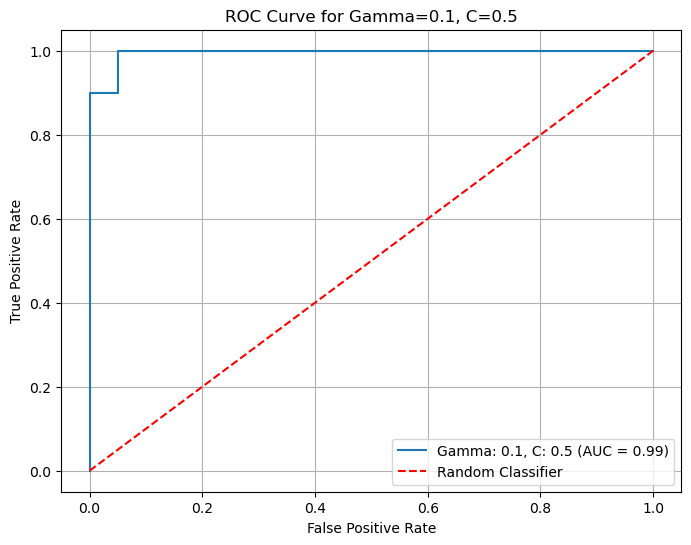

Gamma: 0.1, C: 1


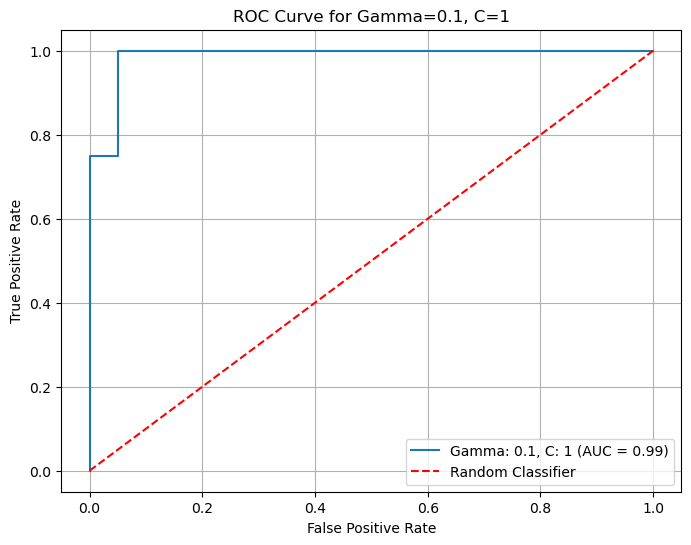

Gamma: 0.1, C: 5


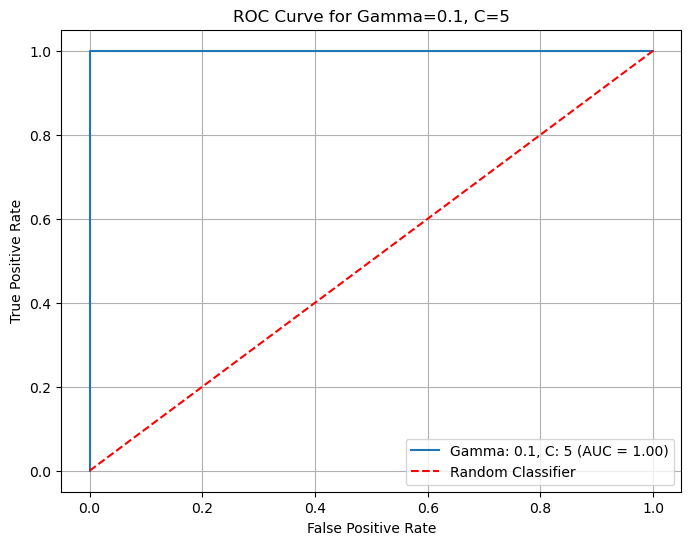

Gamma: 0.5, C: 0.1


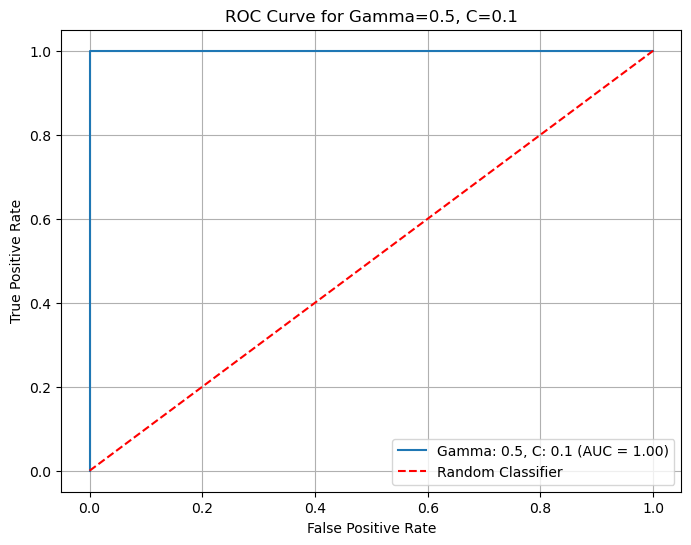

Gamma: 0.5, C: 0.5


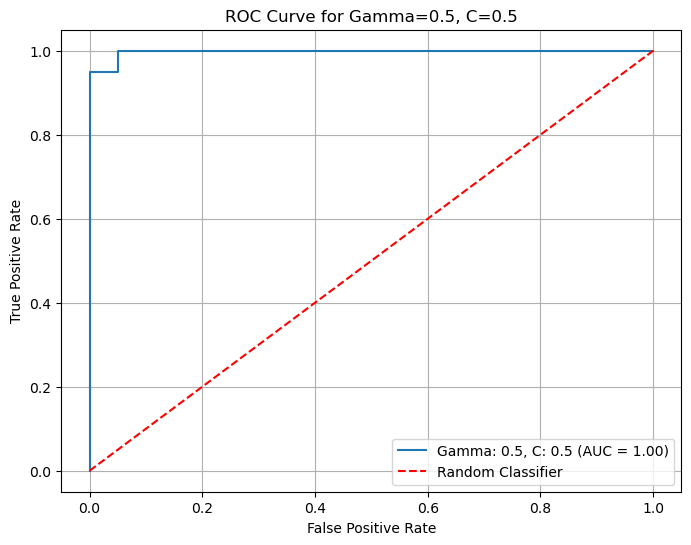

Gamma: 0.5, C: 1


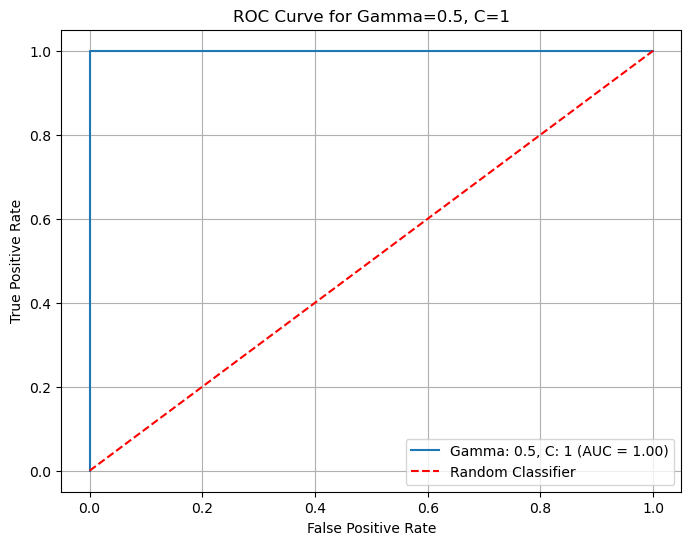

Gamma: 0.5, C: 5


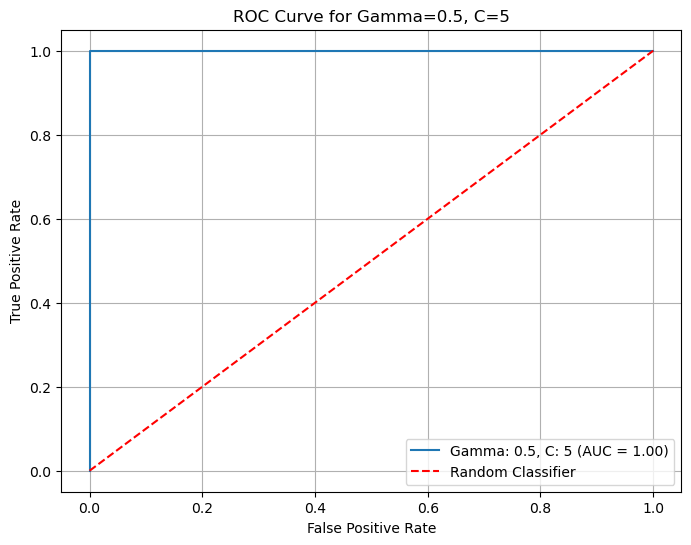

Gamma: 1, C: 0.1


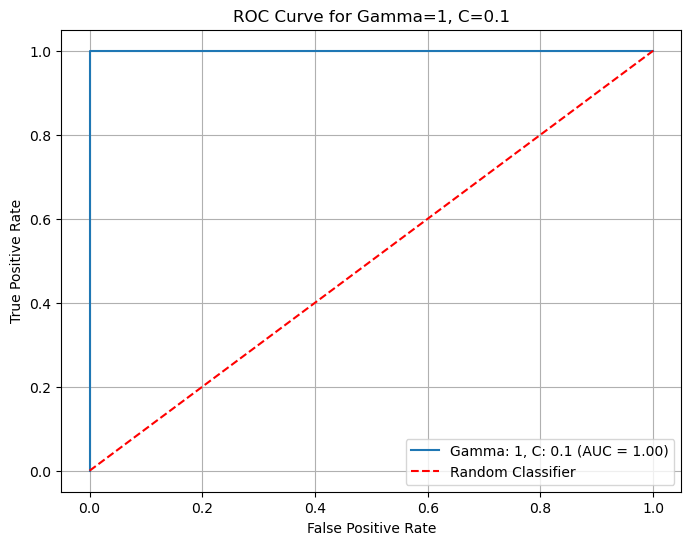

Gamma: 1, C: 0.5


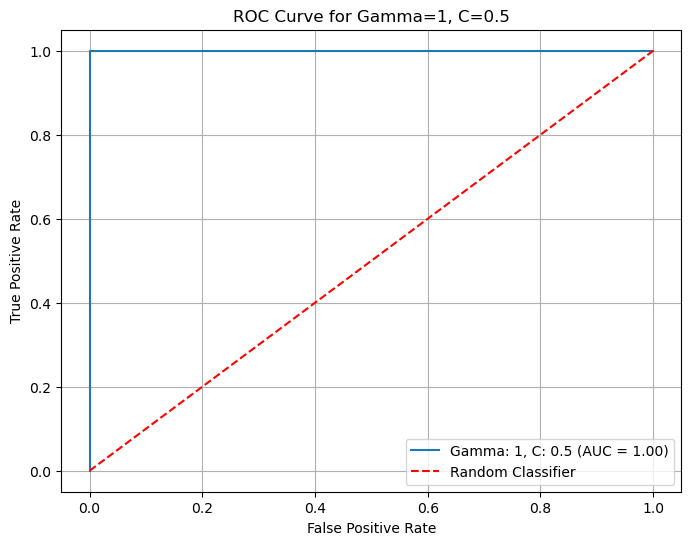

Gamma: 1, C: 1


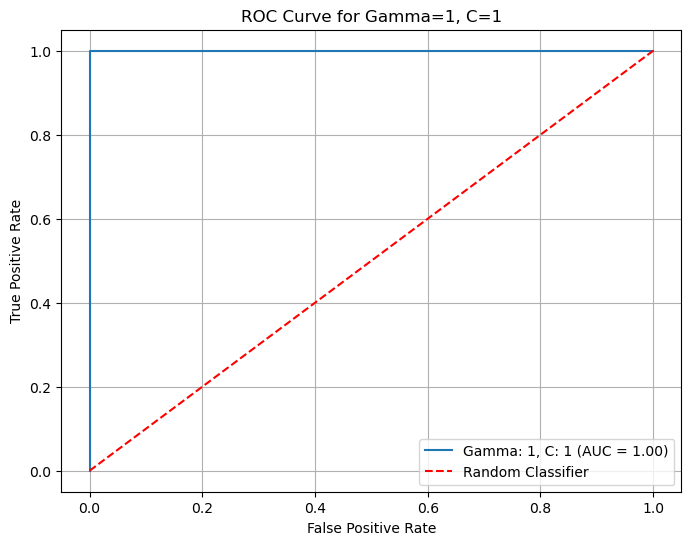

Gamma: 1, C: 5


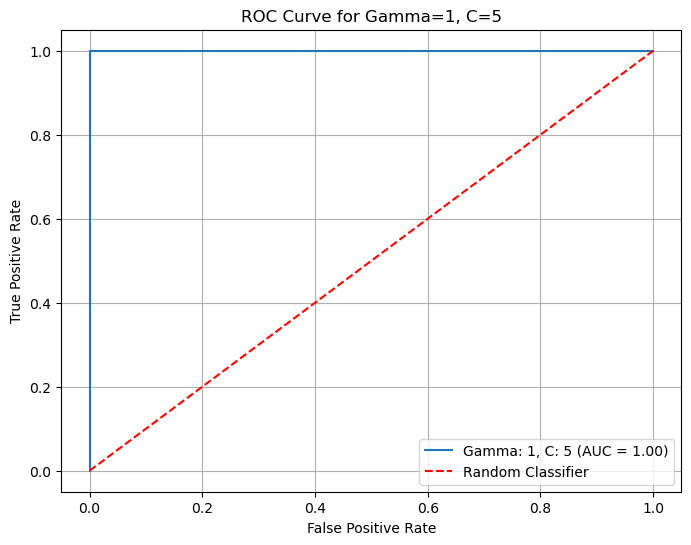

Gamma: 5, C: 0.1


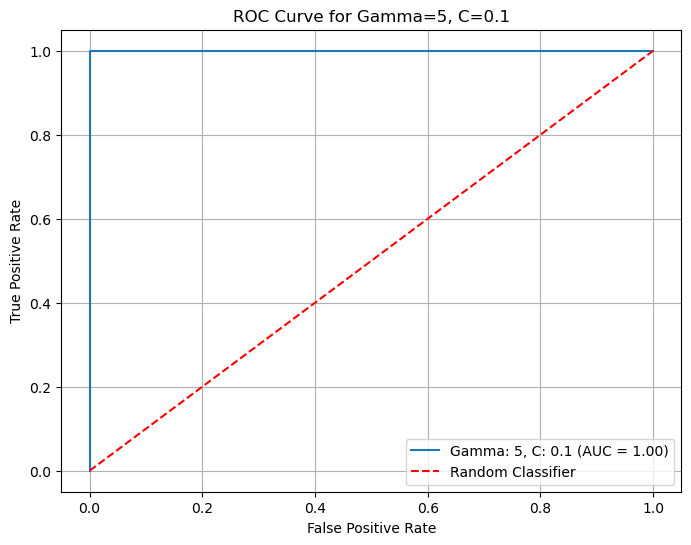

Gamma: 5, C: 0.5


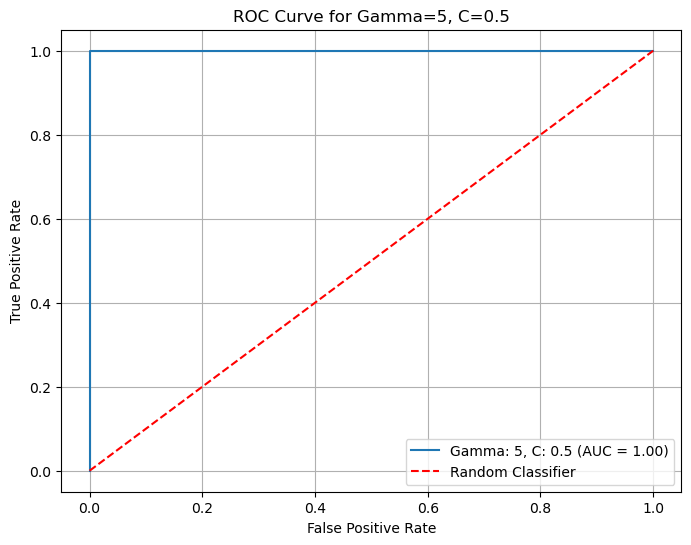

Gamma: 5, C: 1


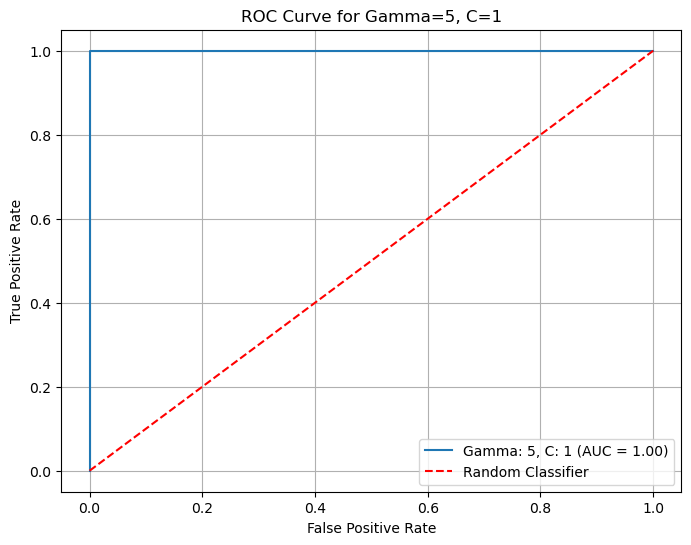

Gamma: 5, C: 5


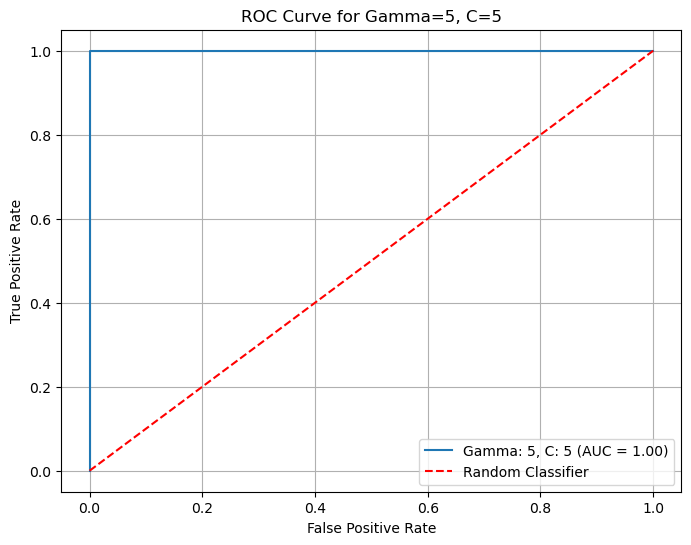

Gamma: 0.01, C: 0.1 -> AUC: 0.99, Testing Accuracy: 50.00%
Gamma: 0.01, C: 0.5 -> AUC: 0.99, Testing Accuracy: 50.00%
Gamma: 0.01, C: 1 -> AUC: 0.99, Testing Accuracy: 50.00%
Gamma: 0.01, C: 5 -> AUC: 0.99, Testing Accuracy: 92.50%
Gamma: 0.05, C: 0.1 -> AUC: 0.99, Testing Accuracy: 50.00%
Gamma: 0.05, C: 0.5 -> AUC: 0.99, Testing Accuracy: 52.50%
Gamma: 0.05, C: 1 -> AUC: 0.99, Testing Accuracy: 95.00%
Gamma: 0.05, C: 5 -> AUC: 0.99, Testing Accuracy: 97.50%
Gamma: 0.1, C: 0.1 -> AUC: 0.99, Testing Accuracy: 50.00%
Gamma: 0.1, C: 0.5 -> AUC: 0.99, Testing Accuracy: 95.00%
Gamma: 0.1, C: 1 -> AUC: 0.99, Testing Accuracy: 97.50%
Gamma: 0.1, C: 5 -> AUC: 1.00, Testing Accuracy: 97.50%
Gamma: 0.5, C: 0.1 -> AUC: 1.00, Testing Accuracy: 77.50%
Gamma: 0.5, C: 0.5 -> AUC: 1.00, Testing Accuracy: 97.50%
Gamma: 0.5, C: 1 -> AUC: 1.00, Testing Accuracy: 97.50%
Gamma: 0.5, C: 5 -> AUC: 1.00, Testing Accuracy: 97.50%
Gamma: 1, C: 0.1 -> AUC: 1.00, Testing Accuracy: 97.50%
Gamma: 1, C: 0.5 -> AUC:

In [338]:
from sklearn.svm import SVC
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Define ranges for gamma and C
gamma_values = [0.01, 0.05, 0.1, 0.5, 1, 5]
C_values = [0.1, 0.5, 1, 5]

# Placeholder to store results
results = []

# Iterate over gamma and C
for gamma in gamma_values:
    for C in C_values:
        print(f"Gamma: {gamma}, C: {C}")
        
        # Train the SVM with the current gamma and C
        model = SVC(kernel="rbf", C=C, gamma=gamma, probability=True)
        model.fit(X_train, y_train)
        
        # Compute decision function for test data
        decision_function_test = model.decision_function(X_test)
        
        # Calculate ROC curve and AUC
        fpr, tpr, thresholds = roc_curve(y_test, decision_function_test)
        roc_auc = auc(fpr, tpr)
        
        # Calculate testing accuracy
        predicted_labels_test = model.predict(X_test)
        testing_accuracy = np.mean(predicted_labels_test == y_test) * 100
        
        # Store the results
        results.append((gamma, C, roc_auc, testing_accuracy))
        
        # Plot the ROC curve
        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, label=f"Gamma: {gamma}, C: {C} (AUC = {roc_auc:.2f})")
        plt.plot([0, 1], [0, 1], linestyle='--', color='red', label="Random Classifier")
        plt.title(f"ROC Curve for Gamma={gamma}, C={C}")
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.legend(loc="lower right")
        plt.grid()
        plt.show()

# Print the summary of results
for gamma, C, roc_auc, testing_accuracy in results:
    print(f"Gamma: {gamma}, C: {C} -> AUC: {roc_auc:.2f}, Testing Accuracy: {testing_accuracy:.2f}%")
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, classification_report, confusion_matrix

# Define RBF Kernel
def rbf_kernel(x1, x2, gamma):
    return np.exp(-gamma * np.linalg.norm(x1 - x2) ** 2)

# Train SVM using dual problem
def train_svm(X_train, y_train, gamma, C):
    n_samples = X_train.shape[0]
    K = np.array([[rbf_kernel(X_train[i], X_train[j], gamma) for j in range(n_samples)] for i in range(n_samples)])
    P = np.outer(y_train, y_train) * K
    q = -np.ones(n_samples)
    G = np.vstack((-np.eye(n_samples), np.eye(n_samples)))
    h = np.hstack((np.zeros(n_samples), np.ones(n_samples) * C))
    A = y_train.astype(float)
    b = np.zeros(1)

    # Solve the optimization problem using cvxopt
    from cvxopt import matrix, solvers
    solvers.options['show_progress'] = False
    P, q, G, h, A, b = map(matrix, [P, q, G, h, A, b])
    solution = solvers.qp(P, q, G, h, A, b)
    alphas = np.ravel(solution['x'])

    # Support vectors
    support_vectors = alphas > 1e-5
    alpha_sv = alphas[support_vectors]
    X_sv = X_train[support_vectors]
    y_sv = y_train[support_vectors]

    # Compute bias term
    b_values = [y_sv[i] - np.sum(alpha_sv * y_sv * K[support_vectors, i]) for i in range(len(y_sv))]
    b = np.mean(b_values)
    return alphas, b, support_vectors

# Compute decision function for testing data
def compute_decision_function(X_train, y_train, alphas, X_test, b, gamma):
    decision_function = []
    for x in X_test:
        score = sum(alphas[i] * y_train[i] * rbf_kernel(X_train[i], x, gamma) for i in range(len(X_train)))
        decision_function.append(score + b)
    return np.array(decision_function)

# Generate data (or replace with your dataset)
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

X, y = make_classification(n_samples=100, n_features=2, n_classes=2, n_clusters_per_class=1, random_state=42)
y = 2 * y - 1  # Convert labels to {-1, 1}
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

# Hyperparameter tuning
gamma_values = [0.01, 0.1, 0.5, 1, 2, 5]
C_values = [0.1, 1, 5]
best_config = None
best_auc = 0

for gamma in gamma_values:
    for C in C_values:
        alphas, b, support_vectors = train_svm(X_train, y_train, gamma, C)
        decision_function_test = compute_decision_function(X_train, y_train, alphas, X_test, b, gamma)

        # ROC curve and AUC
        fpr, tpr, _ = roc_curve(y_test, decision_function_test)
        roc_auc = auc(fpr, tpr)
        testing_accuracy = np.mean((np.sign(decision_function_test) == y_test).astype(float)) * 100

        print(f"Gamma: {gamma}, C: {C} -> AUC: {roc_auc:.2f}, Testing Accuracy: {testing_accuracy:.2f}%")

        # Update best configuration
        if roc_auc > best_auc:
            best_auc = roc_auc
            best_config = (gamma, C, alphas, b)

        # Plot ROC curve
        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, label=f"Gamma = {gamma}, C = {C} (AUC = {roc_auc:.2f})")
        plt.plot([0, 1], [0, 1], linestyle="--", color="red", label="Random Classifier")
        plt.title(f"ROC Curve for Gamma={gamma}, C={C}")
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.legend(loc="lower right")
        plt.grid()
        plt.show()

# Best configuration
print(f"Best Configuration -> Gamma: {best_config[0]}, C: {best_config[1]}, AUC: {best_auc:.2f}")

# Decision Boundary Visualization
xx, yy = np.meshgrid(np.linspace(X_test[:, 0].min() - 1, X_test[:, 0].max() + 1, 200),
                     np.linspace(X_test[:, 1].min() - 1, X_test[:, 1].max() + 1, 200))
grid = np.c_[xx.ravel(), yy.ravel()]
decision_values = np.zeros(grid.shape[0])
for i in range(grid.shape[0]):
    for j in range(len(X_train)):
        decision_values[i] += best_config[2][j] * y_train[j] * rbf_kernel(X_train[j], grid[i], best_config[0])
    decision_values[i] += best_config[3]
decision_values = decision_values.reshape(xx.shape)

plt.figure(figsize=(10, 6))
plt.contourf(xx, yy, decision_values, levels=50, cmap="coolwarm", alpha=0.8)
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap="coolwarm", edgecolors="k", label="Test Data")
plt.title(f"Decision Boundary (Best Config: Gamma={best_config[0]}, C={best_config[1]})")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend()
plt.colorbar(label="Decision Value")
plt.show()


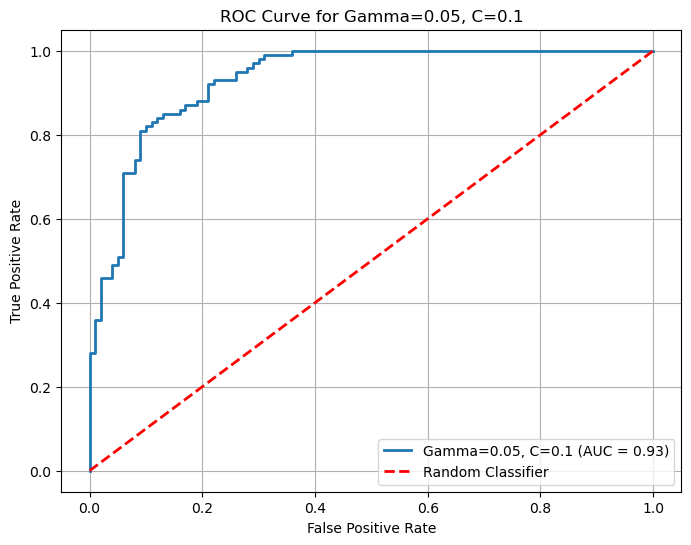

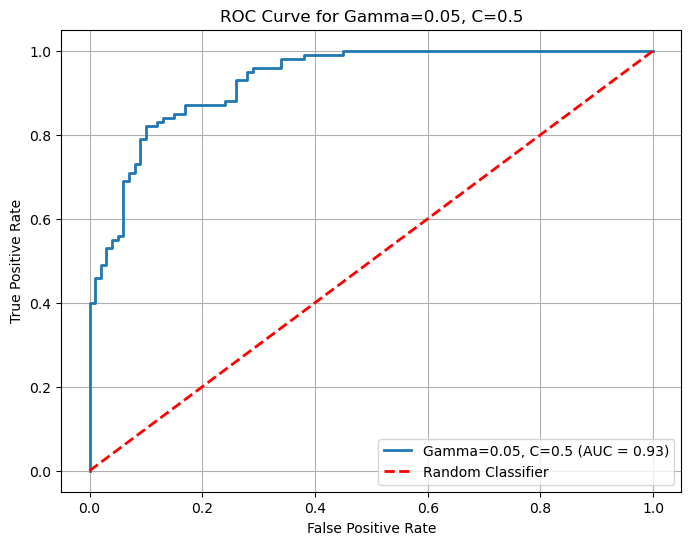

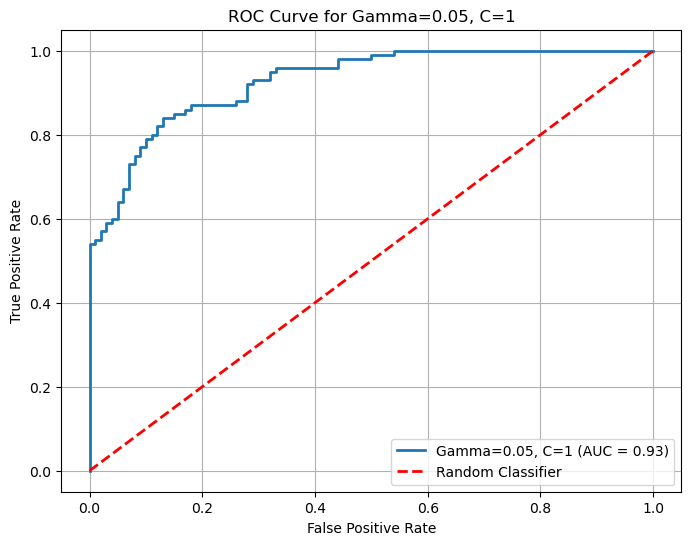

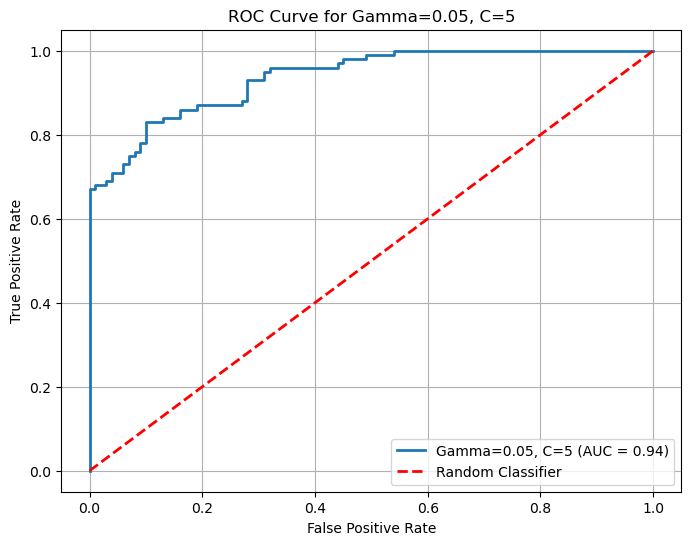

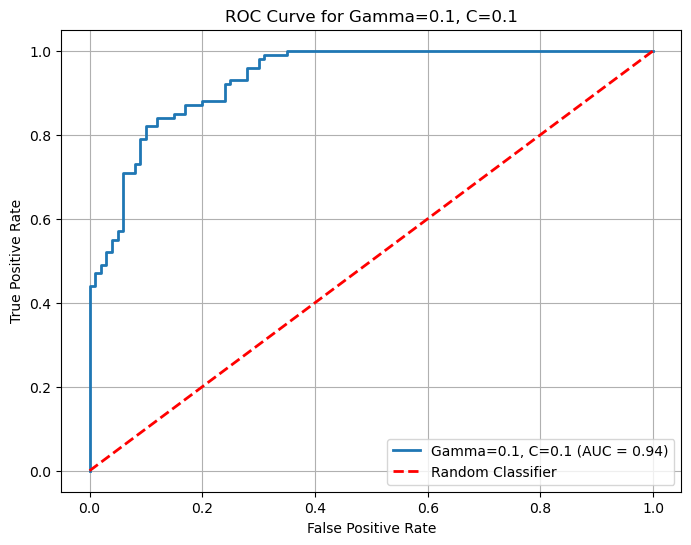

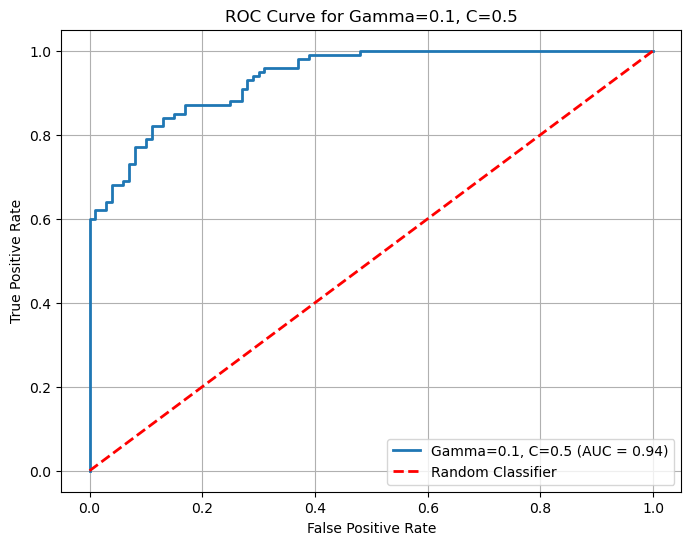

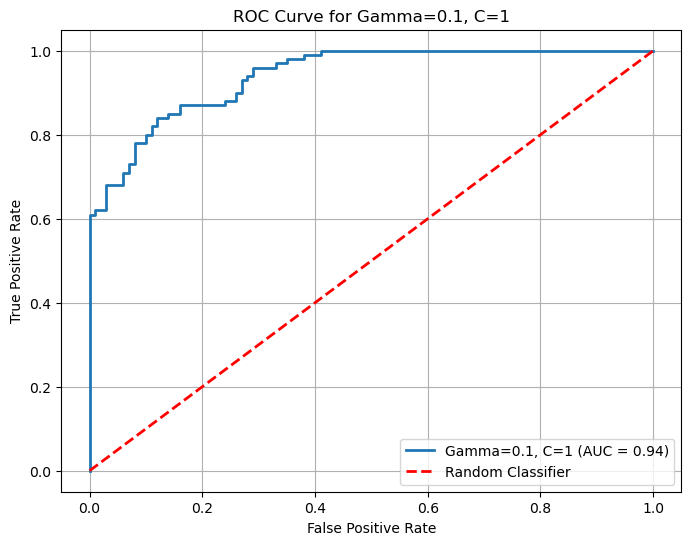

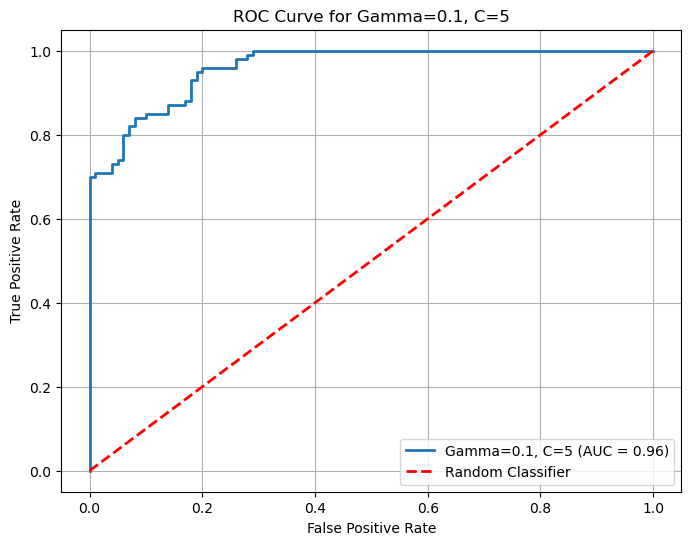

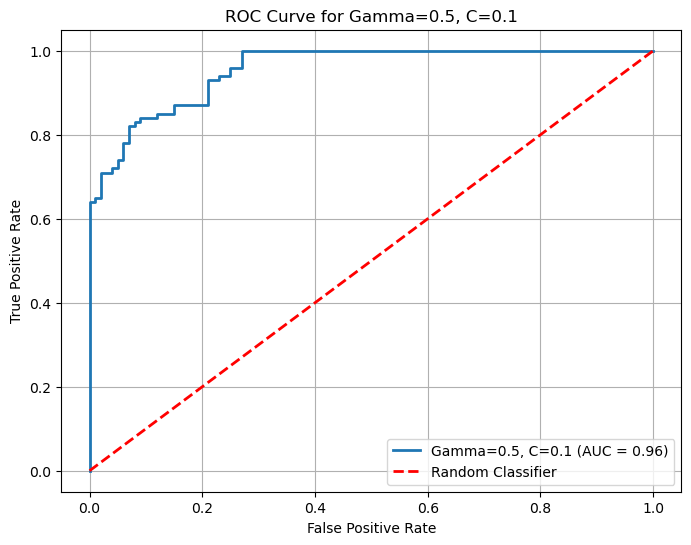

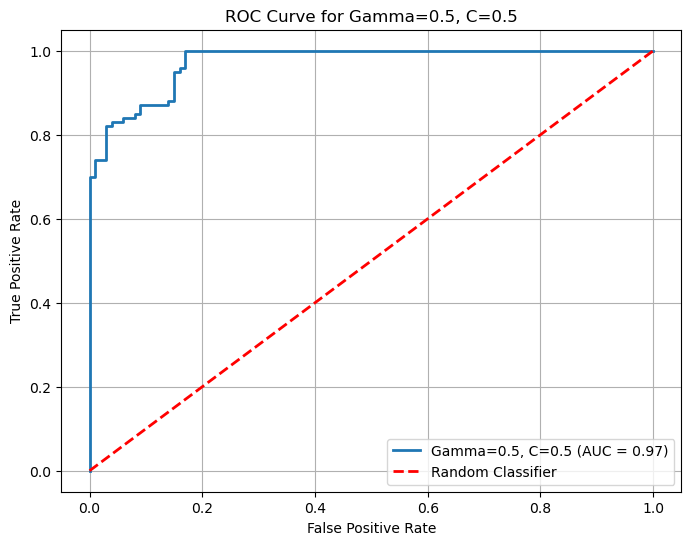

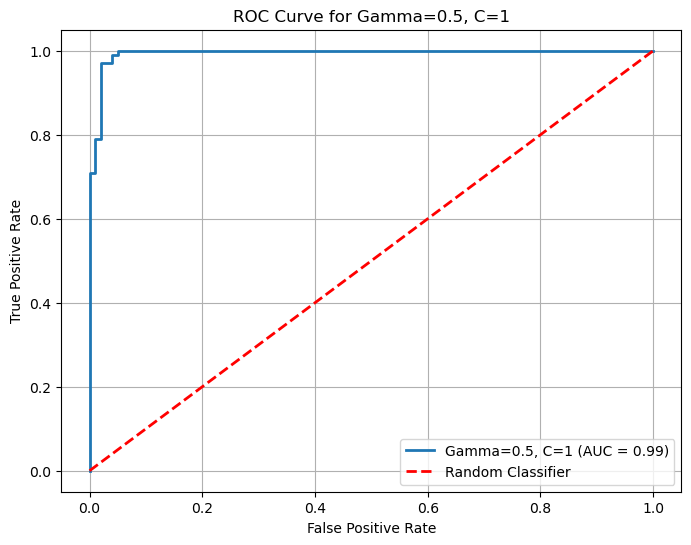

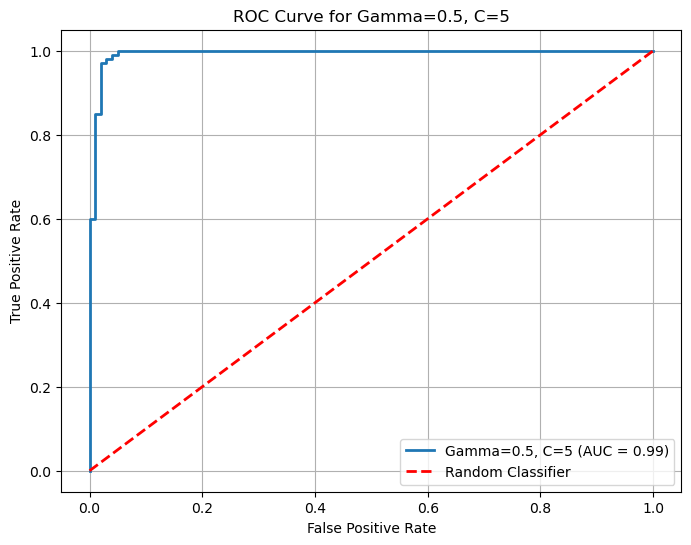

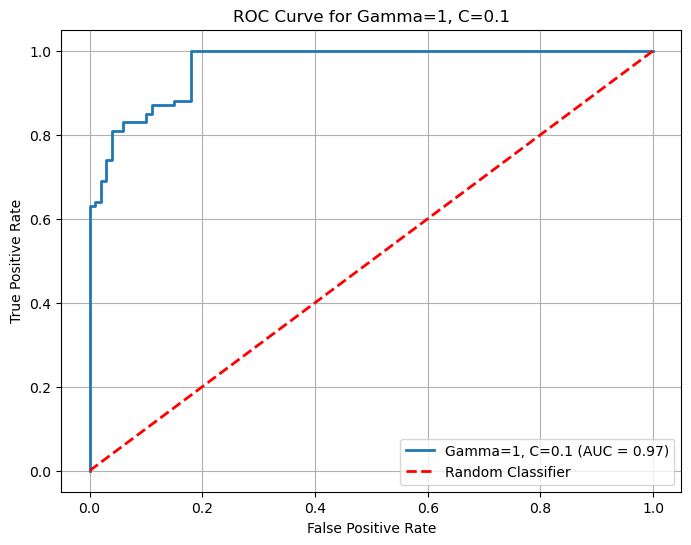

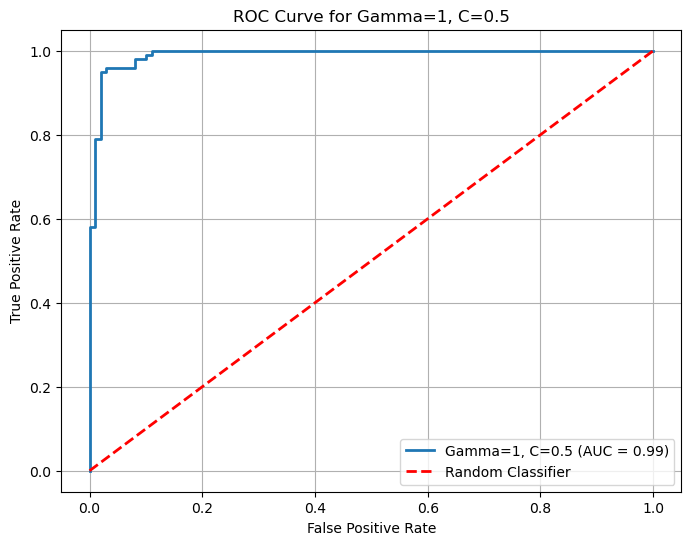

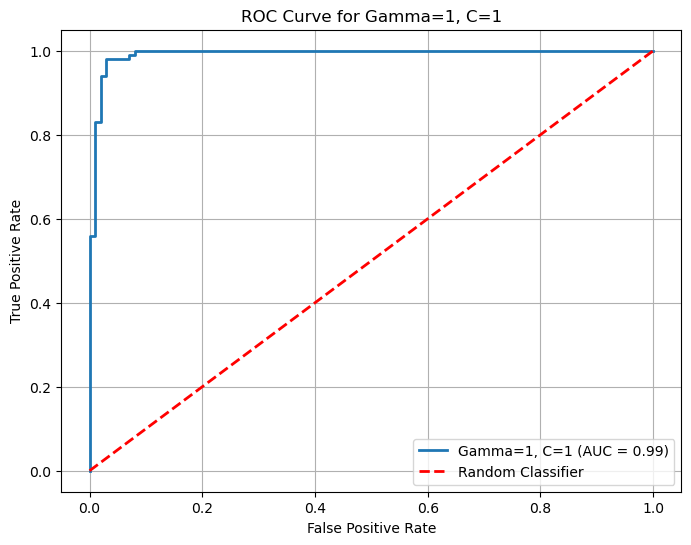

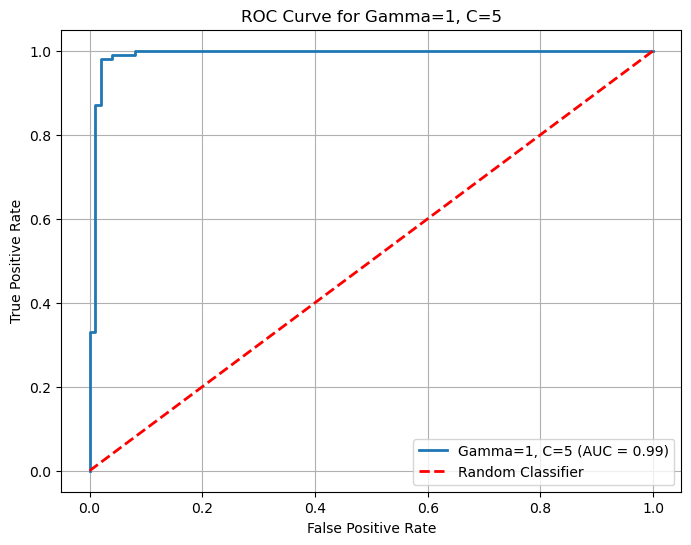

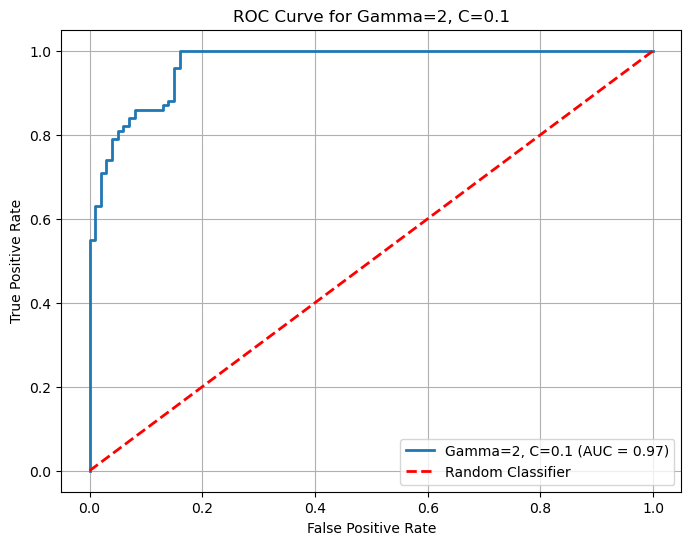

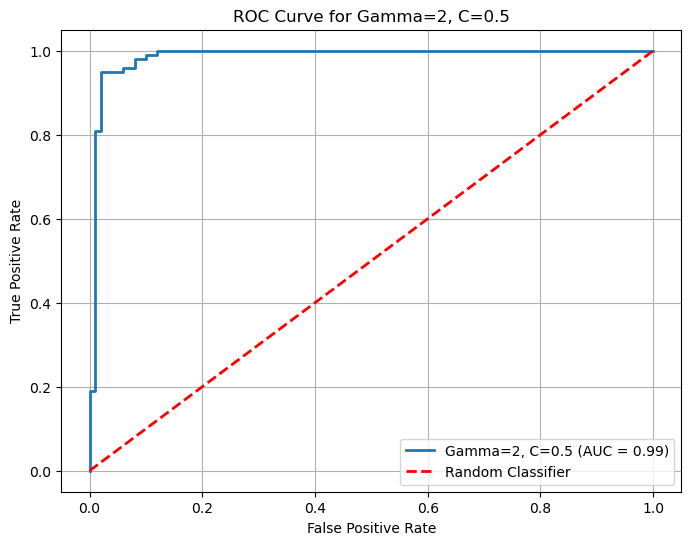

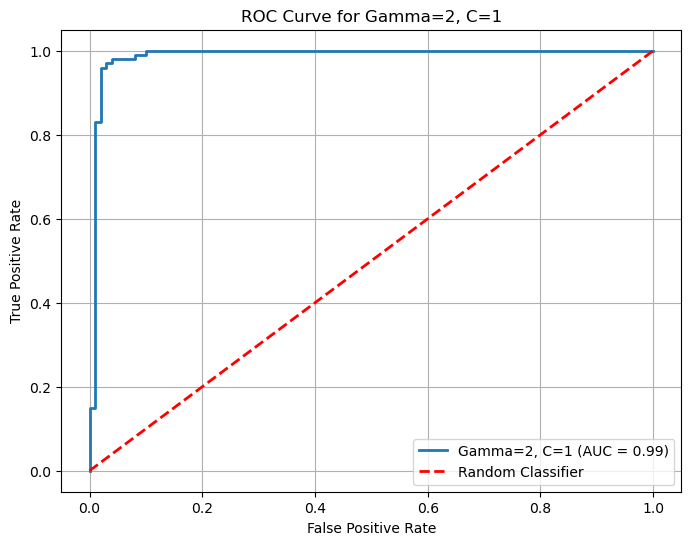

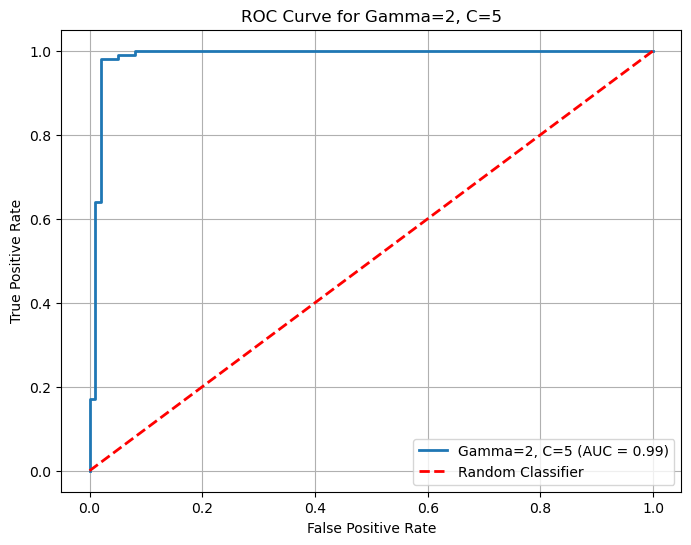

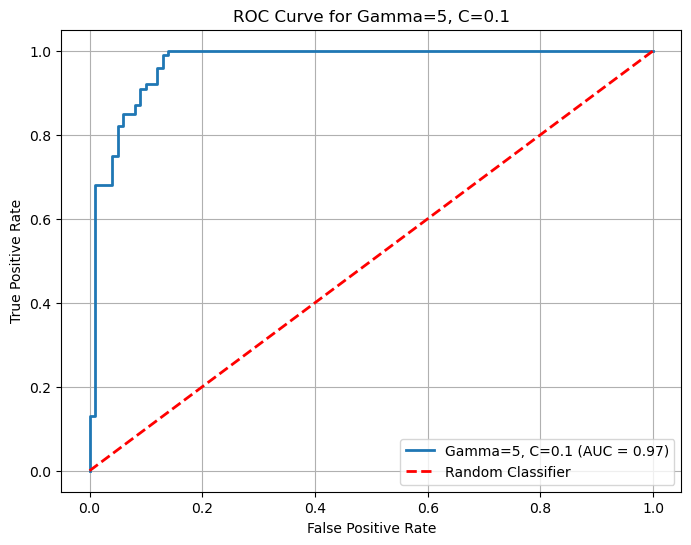

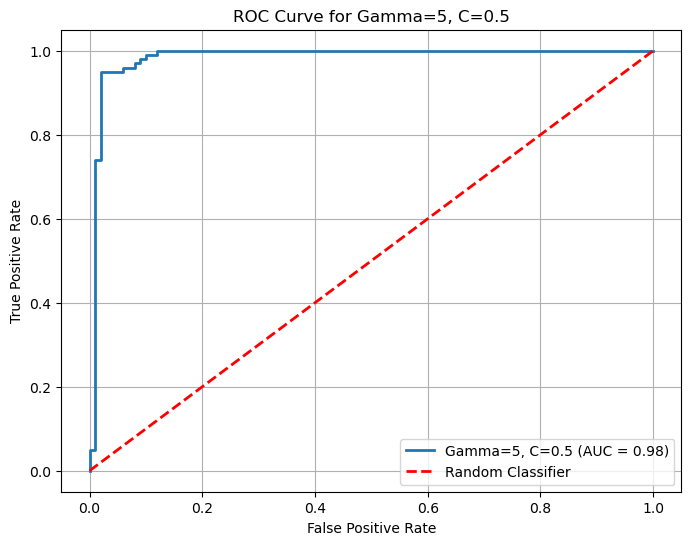

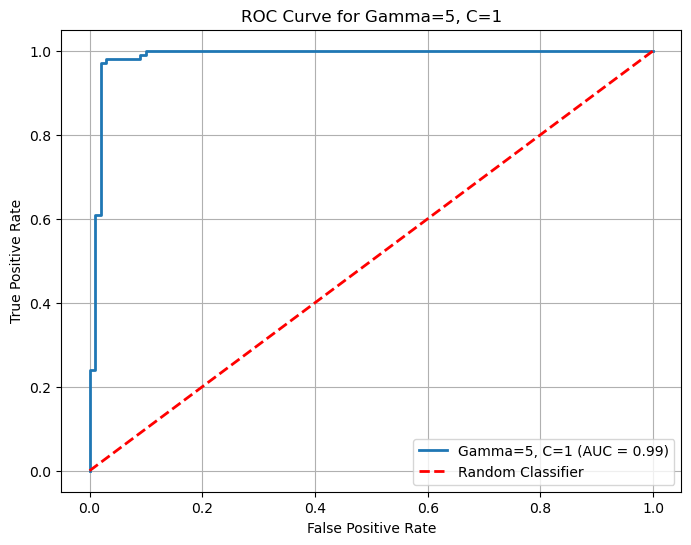

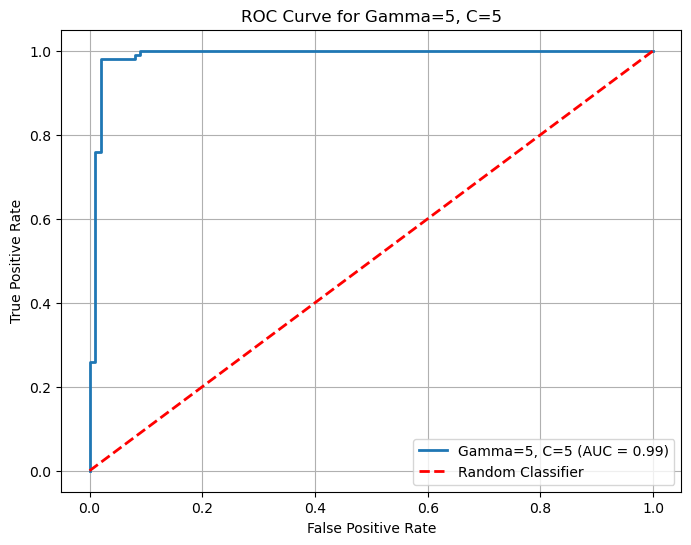

Best Gamma=0.5, C=5 with AUC=0.99 and Accuracy=95.50%


In [3]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification
from sklearn.metrics import roc_curve, auc

# Generate synthetic dataset
X, y = make_classification(
    n_samples=500, n_features=2, n_informative=2, n_redundant=0, n_classes=2,
    n_clusters_per_class=1, random_state=42
)
y = 2 * y - 1  # Convert labels to {-1, 1}
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

# Define RBF Kernel
def rbf_kernel(x1, x2, gamma):
    return np.exp(-gamma * np.linalg.norm(x1 - x2) ** 2)

# Train SVM using Dual Formulation
def train_svm(X, y, gamma, C):
    n_samples = X.shape[0]
    K = np.array([[rbf_kernel(X[i], X[j], gamma) for j in range(n_samples)] for i in range(n_samples)])
    P = np.outer(y, y) * K
    q = -np.ones(n_samples)
    G = np.vstack((-np.eye(n_samples), np.eye(n_samples)))
    h = np.hstack((np.zeros(n_samples), C * np.ones(n_samples)))
    A = y.astype(float).reshape(1, -1)
    b = np.array([0.0])

    # Use cvxopt for solving QP problem
    from cvxopt import matrix, solvers
    solvers.options['show_progress'] = False
    solution = solvers.qp(matrix(P), matrix(q), matrix(G), matrix(h), matrix(A), matrix(b))
    alphas = np.ravel(solution['x'])
    return alphas

# Calculate decision function
def compute_decision_function(X_train, y_train, X, alphas, gamma):
    support_vectors = alphas > 1e-5
    b_values = []
    for i in np.where(support_vectors)[0]:
        kernel_sum = np.sum(alphas[support_vectors] * y_train[support_vectors] *
                            np.array([rbf_kernel(X_train[j], X_train[i], gamma) for j in np.where(support_vectors)[0]]))
        b_values.append(y_train[i] - kernel_sum)
    b = np.mean(b_values)

    decision_function = np.zeros(X.shape[0])
    for i in range(X.shape[0]):
        decision_function[i] = np.sum(alphas[support_vectors] * y_train[support_vectors] *
                                      np.array([rbf_kernel(X_train[j], X[i], gamma) for j in np.where(support_vectors)[0]])) + b
    return decision_function

# Train SVM and Evaluate for Multiple Gamma and C
gammas = [0.05, 0.1, 0.5, 1, 2, 5]
Cs = [0.1, 0.5, 1, 5]
results = []

for gamma in gammas:
    for C in Cs:
        alphas = train_svm(X_train, y_train, gamma=gamma, C=C)
        decision_function_test = compute_decision_function(X_train, y_train, X_test, alphas, gamma)

        # Compute accuracies
        predicted_labels_test = np.sign(decision_function_test)
        testing_accuracy = np.mean(predicted_labels_test == y_test) * 100

        # Compute ROC Curve
        fpr, tpr, _ = roc_curve(y_test, decision_function_test)
        roc_auc = auc(fpr, tpr)
        results.append((gamma, C, roc_auc, testing_accuracy))

        # Plot ROC
        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, label=f"Gamma={gamma}, C={C} (AUC = {roc_auc:.2f})", lw=2)
        plt.plot([0, 1], [0, 1], 'r--', lw=2, label="Random Classifier")
        plt.title(f"ROC Curve for Gamma={gamma}, C={C}")
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.legend(loc="lower right")
        plt.grid()
        plt.show()

# Print Best Result
best_result = max(results, key=lambda x: x[3])  # Maximize testing accuracy
print(f"Best Gamma={best_result[0]}, C={best_result[1]} with AUC={best_result[2]:.2f} and Accuracy={best_result[3]:.2f}%")


In [346]:
# Print all results
print("All Results:")
for gamma, C, roc_auc, testing_accuracy in results:
    print(f"Gamma={gamma}, C={C} -> AUC={roc_auc:.2f}, Accuracy={testing_accuracy:.2f}%")

# Print the best result
best_result = max(results, key=lambda x: x[3])  # Maximize testing accuracy
print("\nBest Result:")
print(f"Best Gamma={best_result[0]}, C={best_result[1]} with AUC={best_result[2]:.2f} and Accuracy={best_result[3]:.2f}%")


All Results:
Gamma=0.05, C=0.1 -> AUC=0.91, Accuracy=85.00%
Gamma=0.05, C=0.5 -> AUC=0.91, Accuracy=85.00%
Gamma=0.05, C=1 -> AUC=0.91, Accuracy=83.75%
Gamma=0.05, C=5 -> AUC=0.91, Accuracy=85.00%
Gamma=0.1, C=0.1 -> AUC=0.91, Accuracy=85.00%
Gamma=0.1, C=0.5 -> AUC=0.91, Accuracy=85.00%
Gamma=0.1, C=1 -> AUC=0.92, Accuracy=85.00%
Gamma=0.1, C=5 -> AUC=0.92, Accuracy=82.50%
Gamma=0.5, C=0.1 -> AUC=0.91, Accuracy=85.00%
Gamma=0.5, C=0.5 -> AUC=0.92, Accuracy=85.00%
Gamma=0.5, C=1 -> AUC=0.91, Accuracy=85.00%
Gamma=0.5, C=5 -> AUC=0.91, Accuracy=85.00%
Gamma=1, C=0.1 -> AUC=0.91, Accuracy=85.00%
Gamma=1, C=0.5 -> AUC=0.91, Accuracy=85.00%
Gamma=1, C=1 -> AUC=0.92, Accuracy=85.00%
Gamma=1, C=5 -> AUC=0.92, Accuracy=85.00%
Gamma=2, C=0.1 -> AUC=0.91, Accuracy=85.00%
Gamma=2, C=0.5 -> AUC=0.92, Accuracy=83.75%
Gamma=2, C=1 -> AUC=0.93, Accuracy=85.00%
Gamma=2, C=5 -> AUC=0.88, Accuracy=85.00%
Gamma=5, C=0.1 -> AUC=0.91, Accuracy=85.00%
Gamma=5, C=0.5 -> AUC=0.92, Accuracy=82.50%
Gamma=5, C=

In [348]:
results = []

for gamma in gamma_values:
    for C in C_values:
        # Train the SVM with the current gamma and C
        alphas = train_svm(X_train, y_train, gamma=gamma, C=C)
        decision_function_train = compute_decision_function(X_train, y_train, X_train, alphas, gamma)
        decision_function_test = compute_decision_function(X_train, y_train, X_test, alphas, gamma)
        
        # Calculate accuracies
        predicted_labels_train = np.sign(decision_function_train)
        predicted_labels_test = np.sign(decision_function_test)
        training_accuracy = np.mean(predicted_labels_train == y_train) * 100
        testing_accuracy = np.mean(predicted_labels_test == y_test) * 100
        
        # Calculate ROC-AUC
        fpr, tpr, _ = roc_curve(y_test, decision_function_test)
        roc_auc = auc(fpr, tpr)
        
        # Store the results
        results.append((gamma, C, roc_auc, training_accuracy, testing_accuracy))

# Print all results
print("All Results:")
for gamma, C, roc_auc, training_accuracy, testing_accuracy in results:
    print(f"Gamma={gamma}, C={C} -> AUC={roc_auc:.2f}, Training Accuracy={training_accuracy:.2f}%, Testing Accuracy={testing_accuracy:.2f}%")

# Print the best result
best_result = max(results, key=lambda x: x[4])  # Maximize testing accuracy
print("\nBest Result:")
print(f"Best Gamma={best_result[0]}, C={best_result[1]} with AUC={best_result[2]:.2f}, Training Accuracy={best_result[3]:.2f}%, and Testing Accuracy={best_result[4]:.2f}%")


All Results:
Gamma=0.01, C=0.1 -> AUC=0.90, Training Accuracy=85.83%, Testing Accuracy=85.00%
Gamma=0.01, C=0.5 -> AUC=0.90, Training Accuracy=85.83%, Testing Accuracy=85.00%
Gamma=0.01, C=1 -> AUC=0.90, Training Accuracy=85.83%, Testing Accuracy=85.00%
Gamma=0.01, C=5 -> AUC=0.90, Training Accuracy=85.83%, Testing Accuracy=85.00%
Gamma=0.05, C=0.1 -> AUC=0.91, Training Accuracy=86.67%, Testing Accuracy=85.00%
Gamma=0.05, C=0.5 -> AUC=0.91, Training Accuracy=86.67%, Testing Accuracy=85.00%
Gamma=0.05, C=1 -> AUC=0.91, Training Accuracy=86.67%, Testing Accuracy=83.75%
Gamma=0.05, C=5 -> AUC=0.91, Training Accuracy=88.33%, Testing Accuracy=85.00%
Gamma=0.1, C=0.1 -> AUC=0.91, Training Accuracy=86.67%, Testing Accuracy=85.00%
Gamma=0.1, C=0.5 -> AUC=0.91, Training Accuracy=88.33%, Testing Accuracy=85.00%
Gamma=0.1, C=1 -> AUC=0.92, Training Accuracy=87.50%, Testing Accuracy=85.00%
Gamma=0.1, C=5 -> AUC=0.92, Training Accuracy=86.67%, Testing Accuracy=82.50%
Gamma=0.5, C=0.1 -> AUC=0.91, T

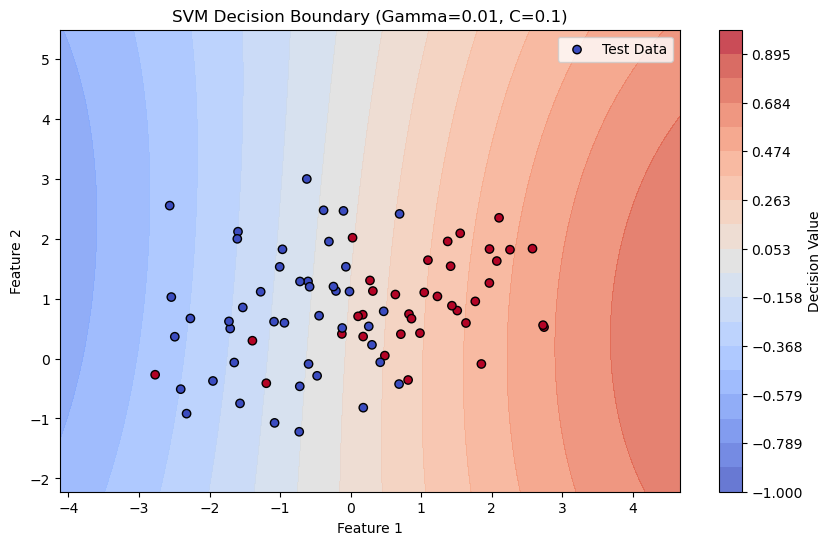

In [350]:
# Retrieve the best parameters
best_gamma, best_C, best_auc, best_training_acc, best_testing_acc = best_result

# Train the SVM with the best parameters
alphas = train_svm(X_train, y_train, gamma=best_gamma, C=best_C)
decision_function_test = compute_decision_function(X_train, y_train, X_test, alphas, best_gamma)

# Generate grid for decision boundary
xx, yy = np.meshgrid(
    np.linspace(X[:, 0].min() - 1, X[:, 0].max() + 1, 200),
    np.linspace(X[:, 1].min() - 1, X[:, 1].max() + 1, 200)
)
grid = np.c_[xx.ravel(), yy.ravel()]

# Compute decision values for the grid
decision_values = np.zeros(grid.shape[0])
for i in range(grid.shape[0]):
    decision_values[i] = np.sum([
        alphas[j] * y_train[j] * rbf_kernel(X_train[j], grid[i], gamma=best_gamma)
        for j in range(len(X_train))
    ])
decision_values = decision_values.reshape(xx.shape)

# Plot the decision boundary
plt.figure(figsize=(10, 6))
plt.contourf(xx, yy, decision_values, levels=np.linspace(-1, 1, 20), cmap="coolwarm", alpha=0.8)
plt.colorbar(label="Decision Value")
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap="coolwarm", edgecolors="k", label="Test Data")
plt.title(f"SVM Decision Boundary (Gamma={best_gamma}, C={best_C})")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend()
plt.show()


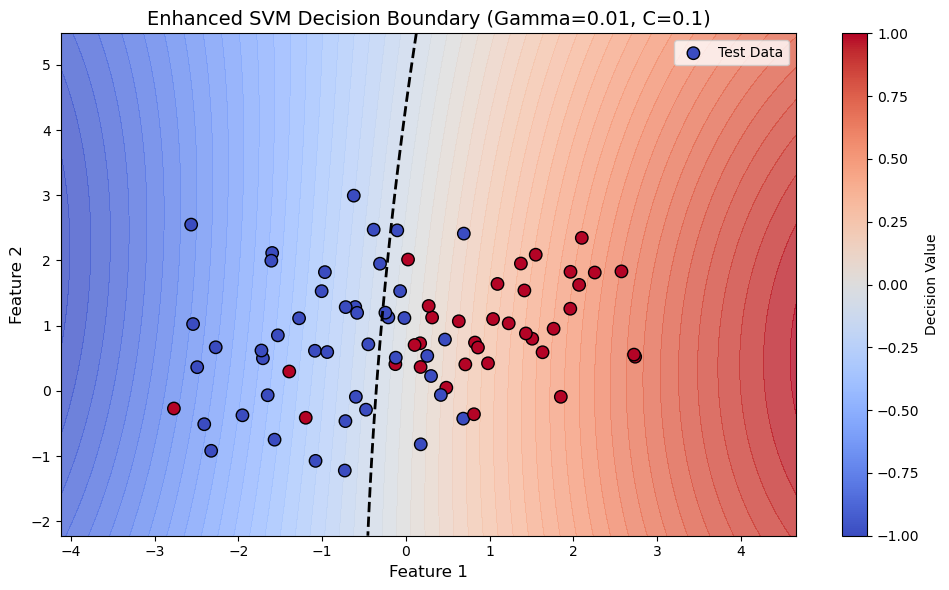

In [352]:
# Plot the decision boundary with enhanced visualization
plt.figure(figsize=(10, 6))

# Contour plot for decision values
plt.contourf(xx, yy, decision_values, levels=50, cmap="coolwarm", alpha=0.8)

# Add a decision boundary line (decision value = 0)
plt.contour(xx, yy, decision_values, levels=[0], colors="black", linewidths=2, linestyles="--")

# Scatter plot for test data
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap="coolwarm", edgecolors="k", s=80, label="Test Data")

# Add colorbar
plt.colorbar(label="Decision Value")

# Title and labels
plt.title(f"Enhanced SVM Decision Boundary (Gamma={best_gamma}, C={best_C})", fontsize=14)
plt.xlabel("Feature 1", fontsize=12)
plt.ylabel("Feature 2", fontsize=12)

# Add legend
plt.legend(fontsize=10)

# Display the plot
plt.tight_layout()
plt.show()


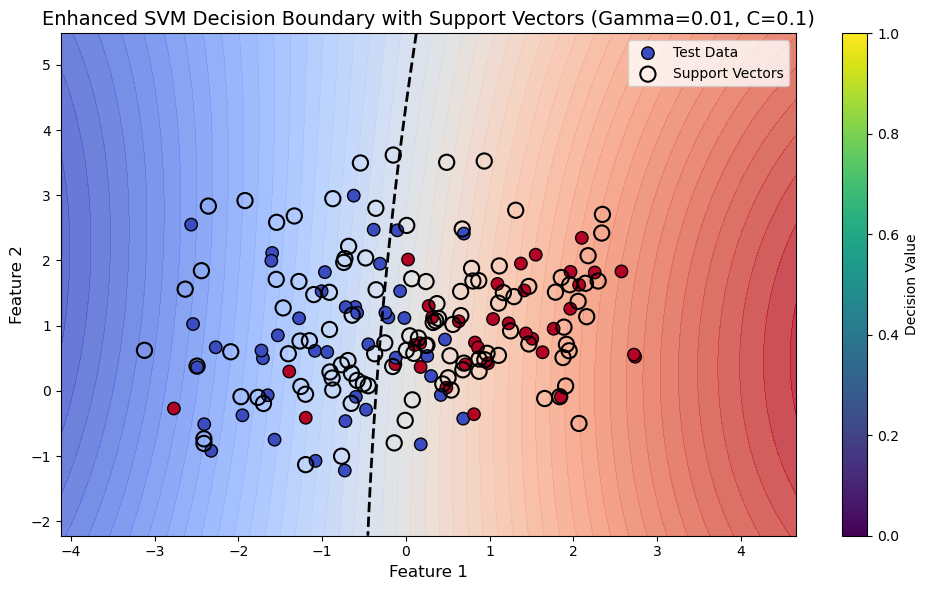

In [354]:
# Highlight support vectors in the decision boundary plot
support_vector_indices = alphas > 1e-5  # Identify support vectors

plt.figure(figsize=(10, 6))

# Contour plot for decision values
plt.contourf(xx, yy, decision_values, levels=50, cmap="coolwarm", alpha=0.8)

# Add a decision boundary line (decision value = 0)
plt.contour(xx, yy, decision_values, levels=[0], colors="black", linewidths=2, linestyles="--")

# Scatter plot for test data
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap="coolwarm", edgecolors="k", s=80, label="Test Data")

# Highlight support vectors
plt.scatter(X_train[support_vector_indices, 0], X_train[support_vector_indices, 1],
            facecolors='none', edgecolors='k', s=120, label="Support Vectors", linewidths=1.5)

# Add colorbar
plt.colorbar(label="Decision Value")

# Title and labels
plt.title(f"Enhanced SVM Decision Boundary with Support Vectors (Gamma={best_gamma}, C={best_C})", fontsize=14)
plt.xlabel("Feature 1", fontsize=12)
plt.ylabel("Feature 2", fontsize=12)

# Add legend
plt.legend(fontsize=10)

# Display the plot
plt.tight_layout()
plt.show()
